<a href="https://colab.research.google.com/github/mohiddin7/Capital_Bike_Share_DATS6101/blob/main/models/classification-models/actiontype.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install transformers datasets torch scikit-learn scikit-multilearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 kB 6.7 MB/s eta 0:00:00


In [ ]:
# def compute_metrics(eval_pred):
#     logits, labels = eval_pred
#     predictions = (torch.sigmoid(torch.tensor(logits)) > 0.5).numpy()  # Apply threshold
#     labels = labels.astype(int)

#     hamming = hamming_loss(labels, predictions)
#     subset_acc = accuracy_score(labels, predictions)
#     report = classification_report(labels, predictions, output_dict=True, zero_division=0)

#     return {
#         "hamming_loss": hamming,
#         "subset_accuracy": subset_acc,
#         "precision_micro": report["micro avg"]["precision"],
#         "recall_micro": report["micro avg"]["recall"],
#         "f1_micro": report["micro avg"]["f1-score"],
#     }

In [12]:
import numpy as np
import pandas as pd
from skmultilearn.model_selection import IterativeStratification

def iterative_train_test_split_custom(X, y, test_size, random_state=None):
    """
    Splits X and y into two sets (train and test) using iterative stratification.
    The test set will have approximately the given test_size fraction of samples.
    """
    stratifier = IterativeStratification(
        n_splits=2,
        order=1,
        sample_distribution_per_fold=[1 - test_size, test_size]
    )
    # The generator returns (train_indices, test_indices)
    for train_idx, test_idx in stratifier.split(X, y):
        return X[test_idx], y[test_idx], X[train_idx], y[train_idx]

def stratified_split(df, x_col, stratify_cols, test_size, val_size=None, random_state=None):
    """
    Splits a DataFrame into stratified sets using iterative stratification.

    Parameters:
      df           : pandas DataFrame.
      x_col        : column name containing the features (e.g., "incident_summary").
      stratify_cols: list of column names to use for stratification.
      train_size   : fraction for training (used for information; priority is given to training and validation).
      test_size    : fraction for test set.
      val_size     : (optional) fraction for validation set. If None, a two-split (train/test) is performed.
      random_state : seed for reproducibility.

    Returns:
      If val_size is None:
         (X_train, y_train, X_test, y_test)
      Else:
         (X_train, y_train, X_val, y_val, X_test, y_test)

    Note: When using a validation set, it is assumed that train_size + test_size + val_size == 1.
    """
    # Shuffle the DataFrame if a random state is provided.
    if random_state is not None:
        df = df.sample(frac=1, random_state=random_state).reset_index(drop=True)

    # Extract features and stratification labels.
    X = df[x_col].values
    y = df[stratify_cols].values

    if val_size is None:
        X_train, y_train, X_test, y_test = iterative_train_test_split_custom(X, y, test_size, random_state)
        return X_train, y_train, X_test, y_test
    else:
        # First, separate out the training data versus the temporary set (which will be split into val and test).
        temp_size = test_size + val_size
        X_train, y_train, X_temp, y_temp = iterative_train_test_split_custom(X, y, temp_size, random_state)

        # Now, split the temporary set into validation and test.
        # The ratio for the test portion of X_temp is: test_size / (test_size + val_size)
        ratio = test_size / temp_size
        X_val, y_val, X_test, y_test = iterative_train_test_split_custom(X_temp, y_temp, ratio, random_state)
        return X_train, y_train, X_val, y_val, X_test, y_test

def label_wise_counts(split_data, labels):
    """
    Calculates label-wise counts for a given data split.
    """
    label_counts = {}
    for i, label_col in enumerate(labels):
        label_counts[label_col] = split_data[:, i].sum()
    return label_counts

In [14]:
import torch
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, hamming_loss, accuracy_score
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments

# =======================
# Generalized Dataset Class
# =======================
class MultiLabelDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "labels": torch.tensor(label, dtype=torch.float),
        }

# =======================
# Function to Compute Metrics
# =======================


from sklearn.metrics import classification_report, hamming_loss, accuracy_score

def compute_metrics(eval_pred, target_names):
    """
    Compute evaluation metrics for multi-label classification.
    Includes Hamming Loss, Subset Accuracy, and Classification Report for all labels.
    """
    logits, labels = eval_pred
    predictions = (torch.sigmoid(torch.tensor(logits)) > 0.5).numpy()  # Apply threshold
    labels = labels.astype(int)

    # Verify Labels
    print("Shape of labels:", labels.shape)  # Ensures correct dimensions
    print("First few rows of labels:\n", labels[:5])  # Shows the first few rows to check for issues
    print("Final target names:", target_names)

    # Hamming Loss
    hamming = hamming_loss(labels, predictions)

    # Subset Accuracy
    subset_acc = accuracy_score(labels, predictions)

    # Classification Report
    report = classification_report(
        labels, predictions,
        target_names=target_names,
        zero_division=0, output_dict=True
    )

    # Print complete report for reference
    print("\nFull Classification Report:")
    print(classification_report(labels, predictions, target_names=target_names, zero_division=0))


    # Summary Metrics for Trainer
    metrics = {
        "hamming_loss": hamming,
        "subset_accuracy": subset_acc,
    }
    metrics.update(report)
    return metrics


# =============================
# Reusable Training Function
# =============================

def train_transformer_model(model_name, data, max_len=512, test_size=0.1, val_size=0.1, batch_size=40, epochs=3):
    """
    Generalized function to train a transformer model for multi-label classification.
    Args:
        model_name: Name of the pre-trained model (e.g., "bert-base-uncased", "distilbert-base-uncased").
        data: Pandas DataFrame with columns "incident_summary" and multi-label columns.
        max_len: Maximum sequence length.
        batch_size: Batch size for training and evaluation.
        epochs: Number of training epochs.
    """

    # Define target names
    target_names = data.drop(columns=["incident_summary"]).columns.tolist()

    # Load tokenizer and model
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=data.shape[1] - 1,  # Number of labels (all columns except "incident_summary")
        problem_type="multi_label_classification",
    )
    model.to("cuda" if torch.cuda.is_available() else "cpu")

    target_names = data.drop(columns=["incident_summary"]).columns.tolist()

    # Split data into train, val, and test
    X = data["incident_summary"]
    y = data.drop('incident_summary', axis=1).values

    # X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42) #stratify=y)
    # X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)




    # X_train, y_train, X_test, y_test = stratified_split(
    #     data,
    #     x_col="incident_summary",
    #     stratify_cols=[col for col in data.columns if col != "incident_summary"],
    #     train_size=0.9,
    #     test_size=0.1,
    #     val_size=None,
    #     random_state=42
    # )



    X_train, y_train, X_val, y_val, X_test, y_test = stratified_split(
        data,
        x_col="incident_summary",
        stratify_cols=[col for col in data.columns if col != "incident_summary"],
        test_size=test_size,
        val_size=val_size,
        random_state=42
    )

    labels = data.drop('incident_summary', axis=1).columns.tolist()

    train_counts = label_wise_counts(y_train, labels)
    val_counts = label_wise_counts(y_val, labels)
    test_counts = label_wise_counts(y_test, labels)

    print("Train Label Counts:")
    print(train_counts)
    print("\nValidation Label Counts:")
    print(val_counts)
    print("\nTest Label Counts:")
    print(test_counts)

    # Create datasets
    train_dataset = MultiLabelDataset(X_train.tolist(), y_train, tokenizer, max_len)
    val_dataset = MultiLabelDataset(X_val.tolist(), y_val, tokenizer, max_len)
    test_dataset = MultiLabelDataset(X_test.tolist(), y_test, tokenizer, max_len)

    # Define training arguments
    training_args = TrainingArguments(
        output_dir="./results",
        evaluation_strategy="epoch",
        save_strategy="epoch",
        learning_rate=2e-5,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=epochs,
        weight_decay=0.01,
        logging_dir="./logs",
        logging_steps=10,
        load_best_model_at_end=True,
        metric_for_best_model='eval_hamming_loss',
        greater_is_better=True,
        save_total_limit=2,
        report_to="none",
    )

    # Initialize Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        processing_class=tokenizer,
        compute_metrics=lambda eval_pred: compute_metrics(eval_pred, target_names)  # ✅ Passing target_names
    )

    # Train and Evaluate
    trainer.train()

    # Final Evaluation on Test Set
    test_results = trainer.evaluate(test_dataset)
    print("Test Set Results:", test_results)

    return trainer, test_results


In [15]:
fraction_labels = {
    1/32: "3%",   # 1/32 = 3.125%
    1/16: "6%",   # 1/16 = 6.25%
    1/8:  "12%",  # 1/8  = 12.5%
    1/4:  "25%",
    1/2:  "50%",
    1.0:  "100%"
}

model_name_labels = {
    "bert-base-cased": "BERT",
    "snowood1/ConfliBERT-scr-cased": "ConfliBERT",
    "FacebookAI/roberta-base": "RoBERTa",
    "distilbert-base-cased": "DistilBERT",
    "xlnet-base-cased": "XLNet",
    "google/electra-base-discriminator": "ELECTRA"
}

fractions = [1/32, 1/16, 1/8, 1/4, 1/2, 1.0]

models_list = [
    "bert-base-cased",
    "snowood1/ConfliBERT-scr-cased",
    "FacebookAI/roberta-base",
    "distilbert-base-cased",
    "xlnet-base-cased",
    "google/electra-base-discriminator"
]

In [16]:
def run_all_experiments_and_save(df_full, output_csv="experiment_results.csv"):
    """
    1. Iterates over the defined fractions & model list
    2. Samples df_full according to fraction
    3. Trains & evaluates using train_multiclass_model_3way_split
    4. Saves the collected results in a DataFrame
    5. Exports to CSV

    Args:
        df_full (pd.DataFrame): Full dataset with columns [label_col, text_col].
        output_csv (str): File path to save the experiment results.
    Returns:
        results_df (pd.DataFrame): Contains experiment results for analysis.
    """
    results_list = []

    for frac in fractions:
        # Sample a fraction of the data
        subset_size = int(len(df_full) * frac)
        df_subset = df_full.sample(n=subset_size, random_state=42)

        # Friendly fraction label if you want
        frac_label = fraction_labels.get(frac, f"{frac*100:.1f}%")
        print(f"\n=== DATA FRACTION: {frac} ({subset_size} rows) ===")

        for model_name in models_list:
            # Model label
            model_label = model_name_labels.get(model_name, model_name)
            print(f"Training model: {model_label}")

            # Train & evaluate
            # write the model funtion here
            trainer, test_results = train_transformer_model(model_name, df_subset, max_len=512, test_size=0.1, val_size=0.1, batch_size=16, epochs=2) # if running on bigger model increase batch size hwere


            # Build a result dict
            run_result = {
                "fraction_raw": frac,
                "fraction_label": frac_label,
                "subset_size": subset_size,
                "model_raw": model_name,
                "model_label": model_label
            }

            # Flatten the nested dictionary
            for key, value in test_results.items():
                if isinstance(value, dict):
                    for subkey, subvalue in value.items():
                        # Create new key names like "armed_assault_precision"
                        run_result[f"{key}_{subkey}"] = subvalue
                else:
                    run_result[key] = value

            # Append to results_list
            results_list.append(run_result)

    # Convert to DataFrame
    results_df = pd.DataFrame(results_list)
    # Save to CSV
    results_df.to_csv(output_csv, index=False)
    print(f"\nResults saved to {output_csv}")

    # also save to JSON
    # results_df.to_json("experiment_results.json", orient="records")

    return results_df




#**Read from GitHub**

In [17]:
import pandas as pd

# Corrected URL to access the raw CSV data
url = 'https://raw.githubusercontent.com/eteitelbaum/code-satp/main/data/action_type.csv'

try:
    data = pd.read_csv(url)
    print(data.head())
except Exception as e:
    print(f"Error loading CSV from URL: {e}")

   armed_assault  arrest  bombing  infrastructure  surrender  seizure  \
0              0       1        0               0          0        0   
1              0       0        0               0          1        0   
2              0       1        0               0          0        0   
3              1       0        0               0          0        0   
4              0       0        1               1          0        0   

   abduction                                   incident_summary  
0          0  An alleged arms supplier to the Communist Part...  
1          0  A Kamareddy dalam (squad) member belonging to ...  
2          0  Senior CPI-Maoist 'Polit Bureau' and 'central ...  
3          0  A TDP leader and former Sarpanch of Jerrela Gr...  
4          0  The CPI-Maoist cadres blasted coffee pulping u...  


# **Read From Drive**

In [ ]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

data = pd.read_csv('/content/drive/MyDrive/colab/satp-data/action_type.csv')

data.head()

Mounted at /content/drive


,armed_assault,arrest,bombing,infrastructure,surrender,seizure,abduction,incident_summary
0,0,1,0,0,0,0,0,An alleged arms supplier to the Communist Part...
1,0,0,0,0,1,0,0,A Kamareddy dalam (squad) member belonging to ...
2,0,1,0,0,0,0,0,Senior CPI-Maoist 'Polit Bureau' and 'central ...
3,1,0,0,0,0,0,0,A TDP leader and former Sarpanch of Jerrela Gr...
4,0,0,1,1,0,0,0,The CPI-Maoist cadres blasted coffee pulping u...


# **Label Wise Counts**

In [18]:
def label_wise_counts(split_data, labels):
    """
    Calculates label-wise counts for a given data split.
    """
    label_counts = {}
    for i, label_col in enumerate(labels):
        label_counts[label_col] = split_data[:, i].sum()
    return label_counts

# Example usage (assuming you have X_train, y_train, X_val, y_val, X_test, y_test from your code)
labels = data.drop('incident_summary', axis=1).columns.tolist()

train_counts = label_wise_counts(y_train, labels)
val_counts = label_wise_counts(y_val, labels)
test_counts = label_wise_counts(y_test, labels)

print("Train Label Counts:")
print(train_counts)
print("\nValidation Label Counts:")
print(val_counts)
print("\nTest Label Counts:")
test_counts

Train Label Counts:
{'armed_assault': np.int64(2861), 'arrest': np.int64(2441), 'bombing': np.int64(913), 'infrastructure': np.int64(879), 'surrender': np.int64(620), 'seizure': np.int64(1718), 'abduction': np.int64(378)}

Validation Label Counts:
{'armed_assault': np.int64(358), 'arrest': np.int64(305), 'bombing': np.int64(114), 'infrastructure': np.int64(110), 'surrender': np.int64(78), 'seizure': np.int64(215), 'abduction': np.int64(47)}

Test Label Counts:


{'armed_assault': np.int64(357),
 'arrest': np.int64(305),
 'bombing': np.int64(114),
 'infrastructure': np.int64(110),
 'surrender': np.int64(77),
 'seizure': np.int64(215),
 'abduction': np.int64(48)}

# **Loop Models**

In [ ]:

# Example usage:
final_results_df = run_all_experiments_and_save(data, output_csv="experiment_results.csv")

# Now you can inspect final_results_df in Python:
print(final_results_df.head())

# If you want to do more analysis, you can pivot, group, or plot the data.



=== DATA FRACTION: 0.03125 (310 rows) ===
Training model: BERT


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Train Label Counts:
{'armed_assault': np.int64(85), 'arrest': np.int64(75), 'bombing': np.int64(21), 'infrastructure': np.int64(30), 'surrender': np.int64(26), 'seizure': np.int64(47), 'abduction': np.int64(12)}

Validation Label Counts:
{'armed_assault': np.int64(10), 'arrest': np.int64(10), 'bombing': np.int64(3), 'infrastructure': np.int64(4), 'surrender': np.int64(3), 'seizure': np.int64(6), 'abduction': np.int64(2)}

Test Label Counts:
{'armed_assault': np.int64(11), 'arrest': np.int64(9), 'bombing': np.int64(2), 'infrastructure': np.int64(4), 'surrender': np.int64(3), 'seizure': np.int64(6), 'abduction': np.int64(1)}


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Hamming Loss,Subset Accuracy,Armed Assault,Arrest,Bombing,Infrastructure,Surrender,Seizure,Abduction,Micro avg,Macro avg,Weighted avg,Samples avg,Runtime,Samples Per Second,Steps Per Second
1,0.643200,0.512604,0.193277,0.264706,"{'precision': 0.34615384615384615, 'recall': 0.9, 'f1-score': 0.5, 'support': 10.0}","{'precision': 0.5, 'recall': 0.1, 'f1-score': 0.16666666666666666, 'support': 10.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 3.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 4.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 3.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 6.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 2.0}","{'precision': 0.35714285714285715, 'recall': 0.2631578947368421, 'f1-score': 0.30303030303030304, 'support': 38.0}","{'precision': 0.12087912087912088, 'recall': 0.14285714285714285, 'f1-score': 0.09523809523809523, 'support': 38.0}","{'precision': 0.22267206477732793, 'recall': 0.2631578947368421, 'f1-score': 0.17543859649122806, 'support': 38.0}","{'precision': 0.29411764705882354, 'recall': 0.27941176470588236, 'f1-score': 0.28431372549019607, 'support': 38.0}",1.010300,33.654000,2.969000
2,0.493200,0.463733,0.155462,0.029412,"{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 10.0}","{'precision': 1.0, 'recall': 0.1, 'f1-score': 0.18181818181818182, 'support': 10.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 3.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 4.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 3.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 6.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 2.0}","{'precision': 1.0, 'recall': 0.02631578947368421, 'f1-score': 0.05128205128205128, 'support': 38.0}","{'precision': 0.14285714285714285, 'recall': 0.014285714285714287, 'f1-score': 0.025974025974025976, 'support': 38.0}","{'precision': 0.2631578947368421, 'recall': 0.02631578947368421, 'f1-score': 0.04784688995215312, 'support': 38.0}","{'precision': 0.029411764705882353, 'recall': 0.029411764705882353, 'f1-score': 0.029411764705882353, 'support': 38.0}",1.028000,33.073000,2.918000


Shape of labels: (34, 7)
First few rows of labels:
 [[0 1 0 0 0 0 0]
 [0 1 0 0 0 0 0]
 [0 0 0 0 0 0 1]
 [0 0 0 1 0 0 0]
 [1 0 0 0 0 0 0]]
Final target names: ['armed_assault', 'arrest', 'bombing', 'infrastructure', 'surrender', 'seizure', 'abduction']

Full Classification Report:
                precision    recall  f1-score   support

 armed_assault       0.35      0.90      0.50        10
        arrest       0.50      0.10      0.17        10
       bombing       0.00      0.00      0.00         3
infrastructure       0.00      0.00      0.00         4
     surrender       0.00      0.00      0.00         3
       seizure       0.00      0.00      0.00         6
     abduction       0.00      0.00      0.00         2

     micro avg       0.36      0.26      0.30        38
     macro avg       0.12      0.14      0.10        38
  weighted avg       0.22      0.26      0.18        38
   samples avg       0.29      0.28      0.28        38

Shape of labels: (34, 7)
First few rows of l

Shape of labels: (31, 7)
First few rows of labels:
 [[0 0 0 0 1 0 0]
 [0 1 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [0 0 0 1 0 1 0]
 [1 0 1 1 0 0 0]]
Final target names: ['armed_assault', 'arrest', 'bombing', 'infrastructure', 'surrender', 'seizure', 'abduction']

Full Classification Report:
                precision    recall  f1-score   support

 armed_assault       0.43      0.82      0.56        11
        arrest       0.00      0.00      0.00         9
       bombing       0.00      0.00      0.00         2
infrastructure       0.00      0.00      0.00         4
     surrender       0.00      0.00      0.00         3
       seizure       0.00      0.00      0.00         6
     abduction       0.00      0.00      0.00         1

     micro avg       0.43      0.25      0.32        36
     macro avg       0.06      0.12      0.08        36
  weighted avg       0.13      0.25      0.17        36
   samples avg       0.29      0.27      0.28        36

Test Set Results: {'eval_loss': 0.5121679902

tokenizer_config.json:   0%|          | 0.00/271 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/218k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/449k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/437M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at snowood1/ConfliBERT-scr-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Train Label Counts:
{'armed_assault': np.int64(85), 'arrest': np.int64(75), 'bombing': np.int64(21), 'infrastructure': np.int64(30), 'surrender': np.int64(26), 'seizure': np.int64(47), 'abduction': np.int64(12)}

Validation Label Counts:
{'armed_assault': np.int64(10), 'arrest': np.int64(10), 'bombing': np.int64(3), 'infrastructure': np.int64(4), 'surrender': np.int64(3), 'seizure': np.int64(6), 'abduction': np.int64(1)}

Test Label Counts:
{'armed_assault': np.int64(11), 'arrest': np.int64(9), 'bombing': np.int64(2), 'infrastructure': np.int64(4), 'surrender': np.int64(3), 'seizure': np.int64(6), 'abduction': np.int64(2)}


model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Epoch,Training Loss,Validation Loss,Hamming Loss,Subset Accuracy,Armed Assault,Arrest,Bombing,Infrastructure,Surrender,Seizure,Abduction,Micro avg,Macro avg,Weighted avg,Samples avg,Runtime,Samples Per Second,Steps Per Second
1,0.569400,0.420014,0.165179,0.000000,"{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 10.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 10.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 3.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 4.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 3.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 6.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 1.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 37.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 37.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 37.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 37.0}",0.996000,32.128000,2.008000
2,0.418900,0.403146,0.165179,0.000000,"{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 10.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 10.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 3.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 4.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 3.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 6.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 1.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 37.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 37.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 37.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 37.0}",1.037700,30.838000,1.927000


Shape of labels: (32, 7)
First few rows of labels:
 [[0 1 0 0 0 0 0]
 [0 1 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [0 0 0 1 0 1 0]
 [0 0 0 1 0 1 0]]
Final target names: ['armed_assault', 'arrest', 'bombing', 'infrastructure', 'surrender', 'seizure', 'abduction']

Full Classification Report:
                precision    recall  f1-score   support

 armed_assault       0.00      0.00      0.00        10
        arrest       0.00      0.00      0.00        10
       bombing       0.00      0.00      0.00         3
infrastructure       0.00      0.00      0.00         4
     surrender       0.00      0.00      0.00         3
       seizure       0.00      0.00      0.00         6
     abduction       0.00      0.00      0.00         1

     micro avg       0.00      0.00      0.00        37
     macro avg       0.00      0.00      0.00        37
  weighted avg       0.00      0.00      0.00        37
   samples avg       0.00      0.00      0.00        37

Shape of labels: (32, 7)
First few rows of l

Shape of labels: (33, 7)
First few rows of labels:
 [[0 0 0 0 1 0 0]
 [0 1 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [0 0 0 0 0 0 1]
 [0 0 0 1 0 0 0]]
Final target names: ['armed_assault', 'arrest', 'bombing', 'infrastructure', 'surrender', 'seizure', 'abduction']

Full Classification Report:
                precision    recall  f1-score   support

 armed_assault       0.00      0.00      0.00        11
        arrest       0.00      0.00      0.00         9
       bombing       0.00      0.00      0.00         2
infrastructure       0.00      0.00      0.00         4
     surrender       0.00      0.00      0.00         3
       seizure       0.00      0.00      0.00         6
     abduction       0.00      0.00      0.00         2

     micro avg       0.00      0.00      0.00        37
     macro avg       0.00      0.00      0.00        37
  weighted avg       0.00      0.00      0.00        37
   samples avg       0.00      0.00      0.00        37

Test Set Results: {'eval_loss': 0.4076946675

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Train Label Counts:
{'armed_assault': np.int64(85), 'arrest': np.int64(75), 'bombing': np.int64(21), 'infrastructure': np.int64(30), 'surrender': np.int64(26), 'seizure': np.int64(47), 'abduction': np.int64(12)}

Validation Label Counts:
{'armed_assault': np.int64(10), 'arrest': np.int64(10), 'bombing': np.int64(3), 'infrastructure': np.int64(4), 'surrender': np.int64(3), 'seizure': np.int64(6), 'abduction': np.int64(1)}

Test Label Counts:
{'armed_assault': np.int64(11), 'arrest': np.int64(9), 'bombing': np.int64(2), 'infrastructure': np.int64(4), 'surrender': np.int64(3), 'seizure': np.int64(6), 'abduction': np.int64(2)}


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Hamming Loss,Subset Accuracy,Armed Assault,Arrest,Bombing,Infrastructure,Surrender,Seizure,Abduction,Micro avg,Macro avg,Weighted avg,Samples avg,Runtime,Samples Per Second,Steps Per Second
1,0.649100,0.456101,0.165179,0.000000,"{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 10.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 10.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 3.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 4.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 3.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 6.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 1.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 37.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 37.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 37.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 37.0}",1.033300,30.970000,1.936000
2,0.444800,0.416856,0.165179,0.000000,"{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 10.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 10.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 3.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 4.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 3.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 6.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 1.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 37.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 37.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 37.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 37.0}",0.924700,34.606000,2.163000


Shape of labels: (32, 7)
First few rows of labels:
 [[0 1 0 0 0 0 0]
 [0 1 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [0 0 0 1 0 1 0]
 [0 0 0 1 0 1 0]]
Final target names: ['armed_assault', 'arrest', 'bombing', 'infrastructure', 'surrender', 'seizure', 'abduction']

Full Classification Report:
                precision    recall  f1-score   support

 armed_assault       0.00      0.00      0.00        10
        arrest       0.00      0.00      0.00        10
       bombing       0.00      0.00      0.00         3
infrastructure       0.00      0.00      0.00         4
     surrender       0.00      0.00      0.00         3
       seizure       0.00      0.00      0.00         6
     abduction       0.00      0.00      0.00         1

     micro avg       0.00      0.00      0.00        37
     macro avg       0.00      0.00      0.00        37
  weighted avg       0.00      0.00      0.00        37
   samples avg       0.00      0.00      0.00        37

Shape of labels: (32, 7)
First few rows of l

Shape of labels: (33, 7)
First few rows of labels:
 [[0 0 0 0 1 0 0]
 [0 1 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [0 0 0 0 0 0 1]
 [0 0 0 1 0 0 0]]
Final target names: ['armed_assault', 'arrest', 'bombing', 'infrastructure', 'surrender', 'seizure', 'abduction']

Full Classification Report:
                precision    recall  f1-score   support

 armed_assault       0.00      0.00      0.00        11
        arrest       0.00      0.00      0.00         9
       bombing       0.00      0.00      0.00         2
infrastructure       0.00      0.00      0.00         4
     surrender       0.00      0.00      0.00         3
       seizure       0.00      0.00      0.00         6
     abduction       0.00      0.00      0.00         2

     micro avg       0.00      0.00      0.00        37
     macro avg       0.00      0.00      0.00        37
  weighted avg       0.00      0.00      0.00        37
   samples avg       0.00      0.00      0.00        37

Test Set Results: {'eval_loss': 0.4532658457

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/465 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/263M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Train Label Counts:
{'armed_assault': np.int64(85), 'arrest': np.int64(75), 'bombing': np.int64(21), 'infrastructure': np.int64(30), 'surrender': np.int64(26), 'seizure': np.int64(47), 'abduction': np.int64(12)}

Validation Label Counts:
{'armed_assault': np.int64(10), 'arrest': np.int64(10), 'bombing': np.int64(3), 'infrastructure': np.int64(4), 'surrender': np.int64(3), 'seizure': np.int64(6), 'abduction': np.int64(1)}

Test Label Counts:
{'armed_assault': np.int64(11), 'arrest': np.int64(9), 'bombing': np.int64(2), 'infrastructure': np.int64(4), 'surrender': np.int64(3), 'seizure': np.int64(6), 'abduction': np.int64(2)}


Epoch,Training Loss,Validation Loss,Hamming Loss,Subset Accuracy,Armed Assault,Arrest,Bombing,Infrastructure,Surrender,Seizure,Abduction,Micro avg,Macro avg,Weighted avg,Samples avg,Runtime,Samples Per Second,Steps Per Second
1,0.659600,0.547314,0.165179,0.000000,"{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 10.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 10.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 3.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 4.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 3.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 6.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 1.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 37.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 37.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 37.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 37.0}",0.522900,61.199000,3.825000
2,0.502900,0.479440,0.165179,0.000000,"{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 10.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 10.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 3.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 4.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 3.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 6.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 1.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 37.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 37.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 37.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 37.0}",0.522800,61.203000,3.825000


Shape of labels: (32, 7)
First few rows of labels:
 [[0 1 0 0 0 0 0]
 [0 1 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [0 0 0 1 0 1 0]
 [0 0 0 1 0 1 0]]
Final target names: ['armed_assault', 'arrest', 'bombing', 'infrastructure', 'surrender', 'seizure', 'abduction']

Full Classification Report:
                precision    recall  f1-score   support

 armed_assault       0.00      0.00      0.00        10
        arrest       0.00      0.00      0.00        10
       bombing       0.00      0.00      0.00         3
infrastructure       0.00      0.00      0.00         4
     surrender       0.00      0.00      0.00         3
       seizure       0.00      0.00      0.00         6
     abduction       0.00      0.00      0.00         1

     micro avg       0.00      0.00      0.00        37
     macro avg       0.00      0.00      0.00        37
  weighted avg       0.00      0.00      0.00        37
   samples avg       0.00      0.00      0.00        37

Shape of labels: (32, 7)
First few rows of l

Shape of labels: (33, 7)
First few rows of labels:
 [[0 0 0 0 1 0 0]
 [0 1 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [0 0 0 0 0 0 1]
 [0 0 0 1 0 0 0]]
Final target names: ['armed_assault', 'arrest', 'bombing', 'infrastructure', 'surrender', 'seizure', 'abduction']

Full Classification Report:
                precision    recall  f1-score   support

 armed_assault       0.00      0.00      0.00        11
        arrest       0.00      0.00      0.00         9
       bombing       0.00      0.00      0.00         2
infrastructure       0.00      0.00      0.00         4
     surrender       0.00      0.00      0.00         3
       seizure       0.00      0.00      0.00         6
     abduction       0.00      0.00      0.00         2

     micro avg       0.00      0.00      0.00        37
     macro avg       0.00      0.00      0.00        37
  weighted avg       0.00      0.00      0.00        37
   samples avg       0.00      0.00      0.00        37

Test Set Results: {'eval_loss': 0.5448785424

config.json:   0%|          | 0.00/760 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/467M [00:00<?, ?B/s]

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Train Label Counts:
{'armed_assault': np.int64(85), 'arrest': np.int64(75), 'bombing': np.int64(21), 'infrastructure': np.int64(30), 'surrender': np.int64(26), 'seizure': np.int64(47), 'abduction': np.int64(12)}

Validation Label Counts:
{'armed_assault': np.int64(10), 'arrest': np.int64(10), 'bombing': np.int64(3), 'infrastructure': np.int64(4), 'surrender': np.int64(3), 'seizure': np.int64(6), 'abduction': np.int64(1)}

Test Label Counts:
{'armed_assault': np.int64(11), 'arrest': np.int64(9), 'bombing': np.int64(2), 'infrastructure': np.int64(4), 'surrender': np.int64(3), 'seizure': np.int64(6), 'abduction': np.int64(2)}


model.safetensors:   0%|          | 0.00/467M [00:00<?, ?B/s]

Epoch,Training Loss,Validation Loss,Hamming Loss,Subset Accuracy,Armed Assault,Arrest,Bombing,Infrastructure,Surrender,Seizure,Abduction,Micro avg,Macro avg,Weighted avg,Samples avg,Runtime,Samples Per Second,Steps Per Second
1,0.522400,0.384300,0.165179,0.000000,"{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 10.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 10.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 3.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 4.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 3.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 6.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 1.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 37.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 37.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 37.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 37.0}",3.523700,9.081000,0.568000
2,0.398900,0.368127,0.156250,0.062500,"{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 10.0}","{'precision': 1.0, 'recall': 0.2, 'f1-score': 0.3333333333333333, 'support': 10.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 3.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 4.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 3.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 6.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 1.0}","{'precision': 1.0, 'recall': 0.05405405405405406, 'f1-score': 0.10256410256410256, 'support': 37.0}","{'precision': 0.14285714285714285, 'recall': 0.028571428571428574, 'f1-score': 0.047619047619047616, 'support': 37.0}","{'precision': 0.2702702702702703, 'recall': 0.05405405405405406, 'f1-score': 0.09009009009009009, 'support': 37.0}","{'precision': 0.0625, 'recall': 0.0625, 'f1-score': 0.0625, 'support': 37.0}",3.523600,9.082000,0.568000


Shape of labels: (32, 7)
First few rows of labels:
 [[0 1 0 0 0 0 0]
 [0 1 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [0 0 0 1 0 1 0]
 [0 0 0 1 0 1 0]]
Final target names: ['armed_assault', 'arrest', 'bombing', 'infrastructure', 'surrender', 'seizure', 'abduction']

Full Classification Report:
                precision    recall  f1-score   support

 armed_assault       0.00      0.00      0.00        10
        arrest       0.00      0.00      0.00        10
       bombing       0.00      0.00      0.00         3
infrastructure       0.00      0.00      0.00         4
     surrender       0.00      0.00      0.00         3
       seizure       0.00      0.00      0.00         6
     abduction       0.00      0.00      0.00         1

     micro avg       0.00      0.00      0.00        37
     macro avg       0.00      0.00      0.00        37
  weighted avg       0.00      0.00      0.00        37
   samples avg       0.00      0.00      0.00        37

Shape of labels: (32, 7)
First few rows of l

Shape of labels: (33, 7)
First few rows of labels:
 [[0 0 0 0 1 0 0]
 [0 1 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [0 0 0 0 0 0 1]
 [0 0 0 1 0 0 0]]
Final target names: ['armed_assault', 'arrest', 'bombing', 'infrastructure', 'surrender', 'seizure', 'abduction']

Full Classification Report:
                precision    recall  f1-score   support

 armed_assault       0.00      0.00      0.00        11
        arrest       0.00      0.00      0.00         9
       bombing       0.00      0.00      0.00         2
infrastructure       0.00      0.00      0.00         4
     surrender       0.00      0.00      0.00         3
       seizure       0.00      0.00      0.00         6
     abduction       0.00      0.00      0.00         2

     micro avg       0.00      0.00      0.00        37
     macro avg       0.00      0.00      0.00        37
  weighted avg       0.00      0.00      0.00        37
   samples avg       0.00      0.00      0.00        37

Test Set Results: {'eval_loss': 0.3794320523

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/666 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Train Label Counts:
{'armed_assault': np.int64(85), 'arrest': np.int64(75), 'bombing': np.int64(21), 'infrastructure': np.int64(30), 'surrender': np.int64(26), 'seizure': np.int64(47), 'abduction': np.int64(12)}

Validation Label Counts:
{'armed_assault': np.int64(10), 'arrest': np.int64(10), 'bombing': np.int64(3), 'infrastructure': np.int64(4), 'surrender': np.int64(3), 'seizure': np.int64(6), 'abduction': np.int64(1)}

Test Label Counts:
{'armed_assault': np.int64(11), 'arrest': np.int64(9), 'bombing': np.int64(2), 'infrastructure': np.int64(4), 'surrender': np.int64(3), 'seizure': np.int64(6), 'abduction': np.int64(2)}


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Epoch,Training Loss,Validation Loss,Hamming Loss,Subset Accuracy,Armed Assault,Arrest,Bombing,Infrastructure,Surrender,Seizure,Abduction,Micro avg,Macro avg,Weighted avg,Samples avg,Runtime,Samples Per Second,Steps Per Second
1,0.648800,0.557218,0.165179,0.000000,"{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 10.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 10.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 3.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 4.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 3.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 6.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 1.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 37.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 37.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 37.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 37.0}",1.126400,28.410000,1.776000
2,0.538300,0.515703,0.165179,0.000000,"{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 10.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 10.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 3.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 4.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 3.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 6.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 1.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 37.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 37.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 37.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 37.0}",1.073900,29.798000,1.862000


Shape of labels: (32, 7)
First few rows of labels:
 [[0 1 0 0 0 0 0]
 [0 1 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [0 0 0 1 0 1 0]
 [0 0 0 1 0 1 0]]
Final target names: ['armed_assault', 'arrest', 'bombing', 'infrastructure', 'surrender', 'seizure', 'abduction']

Full Classification Report:
                precision    recall  f1-score   support

 armed_assault       0.00      0.00      0.00        10
        arrest       0.00      0.00      0.00        10
       bombing       0.00      0.00      0.00         3
infrastructure       0.00      0.00      0.00         4
     surrender       0.00      0.00      0.00         3
       seizure       0.00      0.00      0.00         6
     abduction       0.00      0.00      0.00         1

     micro avg       0.00      0.00      0.00        37
     macro avg       0.00      0.00      0.00        37
  weighted avg       0.00      0.00      0.00        37
   samples avg       0.00      0.00      0.00        37

Shape of labels: (32, 7)
First few rows of l

Shape of labels: (33, 7)
First few rows of labels:
 [[0 0 0 0 1 0 0]
 [0 1 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [0 0 0 0 0 0 1]
 [0 0 0 1 0 0 0]]
Final target names: ['armed_assault', 'arrest', 'bombing', 'infrastructure', 'surrender', 'seizure', 'abduction']

Full Classification Report:
                precision    recall  f1-score   support

 armed_assault       0.00      0.00      0.00        11
        arrest       0.00      0.00      0.00         9
       bombing       0.00      0.00      0.00         2
infrastructure       0.00      0.00      0.00         4
     surrender       0.00      0.00      0.00         3
       seizure       0.00      0.00      0.00         6
     abduction       0.00      0.00      0.00         2

     micro avg       0.00      0.00      0.00        37
     macro avg       0.00      0.00      0.00        37
  weighted avg       0.00      0.00      0.00        37
   samples avg       0.00      0.00      0.00        37

Test Set Results: {'eval_loss': 0.5544375181

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Train Label Counts:
{'armed_assault': np.int64(179), 'arrest': np.int64(146), 'bombing': np.int64(51), 'infrastructure': np.int64(63), 'surrender': np.int64(42), 'seizure': np.int64(94), 'abduction': np.int64(30)}

Validation Label Counts:
{'armed_assault': np.int64(22), 'arrest': np.int64(18), 'bombing': np.int64(7), 'infrastructure': np.int64(8), 'surrender': np.int64(6), 'seizure': np.int64(12), 'abduction': np.int64(4)}

Test Label Counts:
{'armed_assault': np.int64(23), 'arrest': np.int64(18), 'bombing': np.int64(6), 'infrastructure': np.int64(8), 'surrender': np.int64(5), 'seizure': np.int64(11), 'abduction': np.int64(4)}


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Hamming Loss,Subset Accuracy,Armed Assault,Arrest,Bombing,Infrastructure,Surrender,Seizure,Abduction,Micro avg,Macro avg,Weighted avg,Samples avg,Runtime,Samples Per Second,Steps Per Second
1,0.473500,0.438858,0.180328,0.000000,"{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 22.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 18.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 7.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 8.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 6.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 12.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 4.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 77.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 77.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 77.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 77.0}",1.862700,32.748000,2.147000
2,0.409200,0.391672,0.124122,0.295082,"{'precision': 0.8, 'recall': 0.36363636363636365, 'f1-score': 0.5, 'support': 22.0}","{'precision': 1.0, 'recall': 0.9444444444444444, 'f1-score': 0.9714285714285714, 'support': 18.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 7.0}","{'precision': 1.0, 'recall': 0.125, 'f1-score': 0.2222222222222222, 'support': 8.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 6.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 12.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 4.0}","{'precision': 0.9285714285714286, 'recall': 0.33766233766233766, 'f1-score': 0.49523809523809526, 'support': 77.0}","{'precision': 0.39999999999999997, 'recall': 0.2047258297258297, 'f1-score': 0.24195011337868483, 'support': 77.0}","{'precision': 0.5662337662337662, 'recall': 0.33766233766233766, 'f1-score': 0.39303236446093587, 'support': 77.0}","{'precision': 0.4262295081967213, 'recall': 0.36065573770491804, 'f1-score': 0.38251366120218583, 'support': 77.0}",1.878800,32.467000,2.129000


Shape of labels: (61, 7)
First few rows of labels:
 [[0 0 0 1 0 0 0]
 [0 0 1 0 0 0 0]
 [0 0 0 0 1 0 0]
 [0 1 0 0 0 1 0]
 [0 0 0 0 0 1 0]]
Final target names: ['armed_assault', 'arrest', 'bombing', 'infrastructure', 'surrender', 'seizure', 'abduction']

Full Classification Report:
                precision    recall  f1-score   support

 armed_assault       0.00      0.00      0.00        22
        arrest       0.00      0.00      0.00        18
       bombing       0.00      0.00      0.00         7
infrastructure       0.00      0.00      0.00         8
     surrender       0.00      0.00      0.00         6
       seizure       0.00      0.00      0.00        12
     abduction       0.00      0.00      0.00         4

     micro avg       0.00      0.00      0.00        77
     macro avg       0.00      0.00      0.00        77
  weighted avg       0.00      0.00      0.00        77
   samples avg       0.00      0.00      0.00        77

Shape of labels: (61, 7)
First few rows of l

Shape of labels: (62, 7)
First few rows of labels:
 [[1 0 0 0 0 0 0]
 [0 1 0 0 0 0 0]
 [0 0 0 1 0 0 0]
 [1 0 0 0 0 0 0]
 [0 1 0 0 0 0 0]]
Final target names: ['armed_assault', 'arrest', 'bombing', 'infrastructure', 'surrender', 'seizure', 'abduction']

Full Classification Report:
                precision    recall  f1-score   support

 armed_assault       0.00      0.00      0.00        23
        arrest       0.00      0.00      0.00        18
       bombing       0.00      0.00      0.00         6
infrastructure       0.00      0.00      0.00         8
     surrender       0.00      0.00      0.00         5
       seizure       0.00      0.00      0.00        11
     abduction       0.00      0.00      0.00         4

     micro avg       0.00      0.00      0.00        75
     macro avg       0.00      0.00      0.00        75
  weighted avg       0.00      0.00      0.00        75
   samples avg       0.00      0.00      0.00        75

Test Set Results: {'eval_loss': 0.4271848201

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at snowood1/ConfliBERT-scr-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Train Label Counts:
{'armed_assault': np.int64(179), 'arrest': np.int64(146), 'bombing': np.int64(51), 'infrastructure': np.int64(63), 'surrender': np.int64(42), 'seizure': np.int64(94), 'abduction': np.int64(30)}

Validation Label Counts:
{'armed_assault': np.int64(22), 'arrest': np.int64(18), 'bombing': np.int64(7), 'infrastructure': np.int64(8), 'surrender': np.int64(6), 'seizure': np.int64(12), 'abduction': np.int64(4)}

Test Label Counts:
{'armed_assault': np.int64(23), 'arrest': np.int64(18), 'bombing': np.int64(6), 'infrastructure': np.int64(8), 'surrender': np.int64(5), 'seizure': np.int64(11), 'abduction': np.int64(4)}


Epoch,Training Loss,Validation Loss,Hamming Loss,Subset Accuracy,Armed Assault,Arrest,Bombing,Infrastructure,Surrender,Seizure,Abduction,Micro avg,Macro avg,Weighted avg,Samples avg,Runtime,Samples Per Second,Steps Per Second
1,0.411500,0.378197,0.145199,0.245902,"{'precision': 0.8421052631578947, 'recall': 0.7272727272727273, 'f1-score': 0.7804878048780488, 'support': 22.0}","{'precision': 1.0, 'recall': 0.1111111111111111, 'f1-score': 0.2, 'support': 18.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 7.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 8.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 6.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 12.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 4.0}","{'precision': 0.8571428571428571, 'recall': 0.23376623376623376, 'f1-score': 0.3673469387755102, 'support': 77.0}","{'precision': 0.2631578947368421, 'recall': 0.11976911976911978, 'f1-score': 0.14006968641114984, 'support': 77.0}","{'precision': 0.47436773752563227, 'recall': 0.23376623376623376, 'f1-score': 0.2697497624326893, 'support': 77.0}","{'precision': 0.29508196721311475, 'recall': 0.27049180327868855, 'f1-score': 0.2786885245901639, 'support': 77.0}",1.900800,32.091000,2.104000
2,0.344400,0.329370,0.105386,0.409836,"{'precision': 0.8636363636363636, 'recall': 0.8636363636363636, 'f1-score': 0.8636363636363636, 'support': 22.0}","{'precision': 0.9, 'recall': 1.0, 'f1-score': 0.9473684210526315, 'support': 18.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 7.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 8.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 6.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 12.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 4.0}","{'precision': 0.8809523809523809, 'recall': 0.4805194805194805, 'f1-score': 0.6218487394957983, 'support': 77.0}","{'precision': 0.251948051948052, 'recall': 0.26623376623376627, 'f1-score': 0.258714969241285, 'support': 77.0}","{'precision': 0.4571428571428572, 'recall': 0.4805194805194805, 'f1-score': 0.46821599453178403, 'support': 77.0}","{'precision': 0.6065573770491803, 'recall': 0.5081967213114754, 'f1-score': 0.540983606557377, 'support': 77.0}",1.881900,32.415000,2.126000


Shape of labels: (61, 7)
First few rows of labels:
 [[0 0 0 1 0 0 0]
 [0 0 1 0 0 0 0]
 [0 0 0 0 1 0 0]
 [0 1 0 0 0 1 0]
 [0 0 0 0 0 1 0]]
Final target names: ['armed_assault', 'arrest', 'bombing', 'infrastructure', 'surrender', 'seizure', 'abduction']

Full Classification Report:
                precision    recall  f1-score   support

 armed_assault       0.84      0.73      0.78        22
        arrest       1.00      0.11      0.20        18
       bombing       0.00      0.00      0.00         7
infrastructure       0.00      0.00      0.00         8
     surrender       0.00      0.00      0.00         6
       seizure       0.00      0.00      0.00        12
     abduction       0.00      0.00      0.00         4

     micro avg       0.86      0.23      0.37        77
     macro avg       0.26      0.12      0.14        77
  weighted avg       0.47      0.23      0.27        77
   samples avg       0.30      0.27      0.28        77

Shape of labels: (61, 7)
First few rows of l

Shape of labels: (62, 7)
First few rows of labels:
 [[1 0 0 0 0 0 0]
 [0 1 0 0 0 0 0]
 [0 0 0 1 0 0 0]
 [1 0 0 0 0 0 0]
 [0 1 0 0 0 0 0]]
Final target names: ['armed_assault', 'arrest', 'bombing', 'infrastructure', 'surrender', 'seizure', 'abduction']

Full Classification Report:
                precision    recall  f1-score   support

 armed_assault       0.90      0.78      0.84        23
        arrest       1.00      0.11      0.20        18
       bombing       0.00      0.00      0.00         6
infrastructure       0.00      0.00      0.00         8
     surrender       0.00      0.00      0.00         5
       seizure       0.00      0.00      0.00        11
     abduction       0.00      0.00      0.00         4

     micro avg       0.91      0.27      0.41        75
     macro avg       0.27      0.13      0.15        75
  weighted avg       0.52      0.27      0.30        75
   samples avg       0.32      0.31      0.32        75

Test Set Results: {'eval_loss': 0.3627275228

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Train Label Counts:
{'armed_assault': np.int64(179), 'arrest': np.int64(146), 'bombing': np.int64(51), 'infrastructure': np.int64(63), 'surrender': np.int64(42), 'seizure': np.int64(94), 'abduction': np.int64(30)}

Validation Label Counts:
{'armed_assault': np.int64(22), 'arrest': np.int64(18), 'bombing': np.int64(7), 'infrastructure': np.int64(8), 'surrender': np.int64(6), 'seizure': np.int64(12), 'abduction': np.int64(4)}

Test Label Counts:
{'armed_assault': np.int64(23), 'arrest': np.int64(18), 'bombing': np.int64(6), 'infrastructure': np.int64(8), 'surrender': np.int64(5), 'seizure': np.int64(11), 'abduction': np.int64(4)}


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Hamming Loss,Subset Accuracy,Armed Assault,Arrest,Bombing,Infrastructure,Surrender,Seizure,Abduction,Micro avg,Macro avg,Weighted avg,Samples avg,Runtime,Samples Per Second,Steps Per Second
1,0.448600,0.427294,0.180328,0.000000,"{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 22.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 18.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 7.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 8.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 6.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 12.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 4.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 77.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 77.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 77.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 77.0}",1.692800,36.034000,2.363000
2,0.392600,0.366094,0.124122,0.278689,"{'precision': 1.0, 'recall': 0.4090909090909091, 'f1-score': 0.5806451612903226, 'support': 22.0}","{'precision': 1.0, 'recall': 0.8333333333333334, 'f1-score': 0.9090909090909091, 'support': 18.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 7.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 8.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 6.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 12.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 4.0}","{'precision': 1.0, 'recall': 0.3116883116883117, 'f1-score': 0.4752475247524752, 'support': 77.0}","{'precision': 0.2857142857142857, 'recall': 0.1774891774891775, 'f1-score': 0.21281943862589023, 'support': 77.0}","{'precision': 0.5194805194805194, 'recall': 0.3116883116883117, 'f1-score': 0.3784133754808242, 'support': 77.0}","{'precision': 0.39344262295081966, 'recall': 0.3360655737704918, 'f1-score': 0.3551912568306011, 'support': 77.0}",1.701800,35.845000,2.351000


Shape of labels: (61, 7)
First few rows of labels:
 [[0 0 0 1 0 0 0]
 [0 0 1 0 0 0 0]
 [0 0 0 0 1 0 0]
 [0 1 0 0 0 1 0]
 [0 0 0 0 0 1 0]]
Final target names: ['armed_assault', 'arrest', 'bombing', 'infrastructure', 'surrender', 'seizure', 'abduction']

Full Classification Report:
                precision    recall  f1-score   support

 armed_assault       0.00      0.00      0.00        22
        arrest       0.00      0.00      0.00        18
       bombing       0.00      0.00      0.00         7
infrastructure       0.00      0.00      0.00         8
     surrender       0.00      0.00      0.00         6
       seizure       0.00      0.00      0.00        12
     abduction       0.00      0.00      0.00         4

     micro avg       0.00      0.00      0.00        77
     macro avg       0.00      0.00      0.00        77
  weighted avg       0.00      0.00      0.00        77
   samples avg       0.00      0.00      0.00        77

Shape of labels: (61, 7)
First few rows of l

Shape of labels: (62, 7)
First few rows of labels:
 [[1 0 0 0 0 0 0]
 [0 1 0 0 0 0 0]
 [0 0 0 1 0 0 0]
 [1 0 0 0 0 0 0]
 [0 1 0 0 0 0 0]]
Final target names: ['armed_assault', 'arrest', 'bombing', 'infrastructure', 'surrender', 'seizure', 'abduction']

Full Classification Report:
                precision    recall  f1-score   support

 armed_assault       0.00      0.00      0.00        23
        arrest       0.00      0.00      0.00        18
       bombing       0.00      0.00      0.00         6
infrastructure       0.00      0.00      0.00         8
     surrender       0.00      0.00      0.00         5
       seizure       0.00      0.00      0.00        11
     abduction       0.00      0.00      0.00         4

     micro avg       0.00      0.00      0.00        75
     macro avg       0.00      0.00      0.00        75
  weighted avg       0.00      0.00      0.00        75
   samples avg       0.00      0.00      0.00        75

Test Set Results: {'eval_loss': 0.4123979806

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Train Label Counts:
{'armed_assault': np.int64(179), 'arrest': np.int64(146), 'bombing': np.int64(51), 'infrastructure': np.int64(63), 'surrender': np.int64(42), 'seizure': np.int64(94), 'abduction': np.int64(30)}

Validation Label Counts:
{'armed_assault': np.int64(22), 'arrest': np.int64(18), 'bombing': np.int64(7), 'infrastructure': np.int64(8), 'surrender': np.int64(6), 'seizure': np.int64(12), 'abduction': np.int64(4)}

Test Label Counts:
{'armed_assault': np.int64(23), 'arrest': np.int64(18), 'bombing': np.int64(6), 'infrastructure': np.int64(8), 'surrender': np.int64(5), 'seizure': np.int64(11), 'abduction': np.int64(4)}


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Hamming Loss,Subset Accuracy,Armed Assault,Arrest,Bombing,Infrastructure,Surrender,Seizure,Abduction,Micro avg,Macro avg,Weighted avg,Samples avg,Runtime,Samples Per Second,Steps Per Second
1,0.475600,0.449363,0.180328,0.000000,"{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 22.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 18.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 7.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 8.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 6.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 12.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 4.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 77.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 77.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 77.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 77.0}",0.986500,61.834000,4.055000
2,0.433000,0.433148,0.180328,0.000000,"{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 22.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 18.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 7.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 8.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 6.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 12.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 4.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 77.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 77.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 77.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 77.0}",0.956600,63.769000,4.182000


Shape of labels: (61, 7)
First few rows of labels:
 [[0 0 0 1 0 0 0]
 [0 0 1 0 0 0 0]
 [0 0 0 0 1 0 0]
 [0 1 0 0 0 1 0]
 [0 0 0 0 0 1 0]]
Final target names: ['armed_assault', 'arrest', 'bombing', 'infrastructure', 'surrender', 'seizure', 'abduction']

Full Classification Report:
                precision    recall  f1-score   support

 armed_assault       0.00      0.00      0.00        22
        arrest       0.00      0.00      0.00        18
       bombing       0.00      0.00      0.00         7
infrastructure       0.00      0.00      0.00         8
     surrender       0.00      0.00      0.00         6
       seizure       0.00      0.00      0.00        12
     abduction       0.00      0.00      0.00         4

     micro avg       0.00      0.00      0.00        77
     macro avg       0.00      0.00      0.00        77
  weighted avg       0.00      0.00      0.00        77
   samples avg       0.00      0.00      0.00        77

Shape of labels: (61, 7)
First few rows of l

Shape of labels: (62, 7)
First few rows of labels:
 [[1 0 0 0 0 0 0]
 [0 1 0 0 0 0 0]
 [0 0 0 1 0 0 0]
 [1 0 0 0 0 0 0]
 [0 1 0 0 0 0 0]]
Final target names: ['armed_assault', 'arrest', 'bombing', 'infrastructure', 'surrender', 'seizure', 'abduction']

Full Classification Report:
                precision    recall  f1-score   support

 armed_assault       0.00      0.00      0.00        23
        arrest       0.00      0.00      0.00        18
       bombing       0.00      0.00      0.00         6
infrastructure       0.00      0.00      0.00         8
     surrender       0.00      0.00      0.00         5
       seizure       0.00      0.00      0.00        11
     abduction       0.00      0.00      0.00         4

     micro avg       0.00      0.00      0.00        75
     macro avg       0.00      0.00      0.00        75
  weighted avg       0.00      0.00      0.00        75
   samples avg       0.00      0.00      0.00        75

Test Set Results: {'eval_loss': 0.4389358460

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Train Label Counts:
{'armed_assault': np.int64(179), 'arrest': np.int64(146), 'bombing': np.int64(51), 'infrastructure': np.int64(63), 'surrender': np.int64(42), 'seizure': np.int64(94), 'abduction': np.int64(30)}

Validation Label Counts:
{'armed_assault': np.int64(22), 'arrest': np.int64(18), 'bombing': np.int64(7), 'infrastructure': np.int64(8), 'surrender': np.int64(6), 'seizure': np.int64(12), 'abduction': np.int64(4)}

Test Label Counts:
{'armed_assault': np.int64(23), 'arrest': np.int64(18), 'bombing': np.int64(6), 'infrastructure': np.int64(8), 'surrender': np.int64(5), 'seizure': np.int64(11), 'abduction': np.int64(4)}


Epoch,Training Loss,Validation Loss,Hamming Loss,Subset Accuracy,Armed Assault,Arrest,Bombing,Infrastructure,Surrender,Seizure,Abduction,Micro avg,Macro avg,Weighted avg,Samples avg,Runtime,Samples Per Second,Steps Per Second
1,0.401100,0.338689,0.112412,0.360656,"{'precision': 1.0, 'recall': 0.5, 'f1-score': 0.6666666666666666, 'support': 22.0}","{'precision': 1.0, 'recall': 0.8333333333333334, 'f1-score': 0.9090909090909091, 'support': 18.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 7.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 8.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 6.0}","{'precision': 1.0, 'recall': 0.25, 'f1-score': 0.4, 'support': 12.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 4.0}","{'precision': 1.0, 'recall': 0.37662337662337664, 'f1-score': 0.5471698113207547, 'support': 77.0}","{'precision': 0.42857142857142855, 'recall': 0.22619047619047622, 'f1-score': 0.28225108225108225, 'support': 77.0}","{'precision': 0.6753246753246753, 'recall': 0.37662337662337664, 'f1-score': 0.46532861078315624, 'support': 77.0}","{'precision': 0.47540983606557374, 'recall': 0.4180327868852459, 'f1-score': 0.43715846994535523, 'support': 77.0}",6.611500,9.226000,0.605000
2,0.298100,0.251672,0.081967,0.524590,"{'precision': 0.875, 'recall': 0.9545454545454546, 'f1-score': 0.9130434782608695, 'support': 22.0}","{'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 18.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 7.0}","{'precision': 1.0, 'recall': 0.125, 'f1-score': 0.2222222222222222, 'support': 8.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 6.0}","{'precision': 1.0, 'recall': 0.4166666666666667, 'f1-score': 0.5882352941176471, 'support': 12.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 4.0}","{'precision': 0.9375, 'recall': 0.5844155844155844, 'f1-score': 0.72, 'support': 77.0}","{'precision': 0.5535714285714286, 'recall': 0.3566017316017316, 'f1-score': 0.38907157065724846, 'support': 77.0}","{'precision': 0.7435064935064936, 'recall': 0.5844155844155844, 'f1-score': 0.6093968549211515, 'support': 77.0}","{'precision': 0.6885245901639344, 'recall': 0.6038251366120218, 'f1-score': 0.6311475409836065, 'support': 77.0}",6.635100,9.194000,0.603000


Shape of labels: (61, 7)
First few rows of labels:
 [[0 0 0 1 0 0 0]
 [0 0 1 0 0 0 0]
 [0 0 0 0 1 0 0]
 [0 1 0 0 0 1 0]
 [0 0 0 0 0 1 0]]
Final target names: ['armed_assault', 'arrest', 'bombing', 'infrastructure', 'surrender', 'seizure', 'abduction']

Full Classification Report:
                precision    recall  f1-score   support

 armed_assault       1.00      0.50      0.67        22
        arrest       1.00      0.83      0.91        18
       bombing       0.00      0.00      0.00         7
infrastructure       0.00      0.00      0.00         8
     surrender       0.00      0.00      0.00         6
       seizure       1.00      0.25      0.40        12
     abduction       0.00      0.00      0.00         4

     micro avg       1.00      0.38      0.55        77
     macro avg       0.43      0.23      0.28        77
  weighted avg       0.68      0.38      0.47        77
   samples avg       0.48      0.42      0.44        77

Shape of labels: (61, 7)
First few rows of l

Shape of labels: (62, 7)
First few rows of labels:
 [[1 0 0 0 0 0 0]
 [0 1 0 0 0 0 0]
 [0 0 0 1 0 0 0]
 [1 0 0 0 0 0 0]
 [0 1 0 0 0 0 0]]
Final target names: ['armed_assault', 'arrest', 'bombing', 'infrastructure', 'surrender', 'seizure', 'abduction']

Full Classification Report:
                precision    recall  f1-score   support

 armed_assault       0.92      0.48      0.63        23
        arrest       1.00      0.89      0.94        18
       bombing       0.00      0.00      0.00         6
infrastructure       0.00      0.00      0.00         8
     surrender       0.00      0.00      0.00         5
       seizure       1.00      0.18      0.31        11
     abduction       0.00      0.00      0.00         4

     micro avg       0.97      0.39      0.55        75
     macro avg       0.42      0.22      0.27        75
  weighted avg       0.67      0.39      0.46        75
   samples avg       0.44      0.40      0.41        75

Test Set Results: {'eval_loss': 0.3254368603

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Train Label Counts:
{'armed_assault': np.int64(179), 'arrest': np.int64(146), 'bombing': np.int64(51), 'infrastructure': np.int64(63), 'surrender': np.int64(42), 'seizure': np.int64(94), 'abduction': np.int64(30)}

Validation Label Counts:
{'armed_assault': np.int64(22), 'arrest': np.int64(18), 'bombing': np.int64(7), 'infrastructure': np.int64(8), 'surrender': np.int64(6), 'seizure': np.int64(12), 'abduction': np.int64(4)}

Test Label Counts:
{'armed_assault': np.int64(23), 'arrest': np.int64(18), 'bombing': np.int64(6), 'infrastructure': np.int64(8), 'surrender': np.int64(5), 'seizure': np.int64(11), 'abduction': np.int64(4)}


Epoch,Training Loss,Validation Loss,Hamming Loss,Subset Accuracy,Armed Assault,Arrest,Bombing,Infrastructure,Surrender,Seizure,Abduction,Micro avg,Macro avg,Weighted avg,Samples avg,Runtime,Samples Per Second,Steps Per Second
1,0.519400,0.487274,0.180328,0.000000,"{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 22.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 18.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 7.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 8.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 6.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 12.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 4.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 77.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 77.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 77.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 77.0}",1.986900,30.701000,2.013000
2,0.472100,0.462959,0.180328,0.000000,"{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 22.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 18.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 7.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 8.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 6.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 12.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 4.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 77.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 77.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 77.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 77.0}",2.045200,29.826000,1.956000


Shape of labels: (61, 7)
First few rows of labels:
 [[0 0 0 1 0 0 0]
 [0 0 1 0 0 0 0]
 [0 0 0 0 1 0 0]
 [0 1 0 0 0 1 0]
 [0 0 0 0 0 1 0]]
Final target names: ['armed_assault', 'arrest', 'bombing', 'infrastructure', 'surrender', 'seizure', 'abduction']

Full Classification Report:
                precision    recall  f1-score   support

 armed_assault       0.00      0.00      0.00        22
        arrest       0.00      0.00      0.00        18
       bombing       0.00      0.00      0.00         7
infrastructure       0.00      0.00      0.00         8
     surrender       0.00      0.00      0.00         6
       seizure       0.00      0.00      0.00        12
     abduction       0.00      0.00      0.00         4

     micro avg       0.00      0.00      0.00        77
     macro avg       0.00      0.00      0.00        77
  weighted avg       0.00      0.00      0.00        77
   samples avg       0.00      0.00      0.00        77

Shape of labels: (61, 7)
First few rows of l

Shape of labels: (62, 7)
First few rows of labels:
 [[1 0 0 0 0 0 0]
 [0 1 0 0 0 0 0]
 [0 0 0 1 0 0 0]
 [1 0 0 0 0 0 0]
 [0 1 0 0 0 0 0]]
Final target names: ['armed_assault', 'arrest', 'bombing', 'infrastructure', 'surrender', 'seizure', 'abduction']

Full Classification Report:
                precision    recall  f1-score   support

 armed_assault       0.00      0.00      0.00        23
        arrest       0.00      0.00      0.00        18
       bombing       0.00      0.00      0.00         6
infrastructure       0.00      0.00      0.00         8
     surrender       0.00      0.00      0.00         5
       seizure       0.00      0.00      0.00        11
     abduction       0.00      0.00      0.00         4

     micro avg       0.00      0.00      0.00        75
     macro avg       0.00      0.00      0.00        75
  weighted avg       0.00      0.00      0.00        75
   samples avg       0.00      0.00      0.00        75

Test Set Results: {'eval_loss': 0.4790481626

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Train Label Counts:
{'armed_assault': np.int64(362), 'arrest': np.int64(290), 'bombing': np.int64(110), 'infrastructure': np.int64(116), 'surrender': np.int64(76), 'seizure': np.int64(204), 'abduction': np.int64(55)}

Validation Label Counts:
{'armed_assault': np.int64(46), 'arrest': np.int64(36), 'bombing': np.int64(14), 'infrastructure': np.int64(15), 'surrender': np.int64(9), 'seizure': np.int64(26), 'abduction': np.int64(7)}

Test Label Counts:
{'armed_assault': np.int64(45), 'arrest': np.int64(37), 'bombing': np.int64(13), 'infrastructure': np.int64(14), 'surrender': np.int64(10), 'seizure': np.int64(25), 'abduction': np.int64(7)}


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Hamming Loss,Subset Accuracy,Armed Assault,Arrest,Bombing,Infrastructure,Surrender,Seizure,Abduction,Micro avg,Macro avg,Weighted avg,Samples avg,Runtime,Samples Per Second,Steps Per Second
1,0.358100,0.326548,0.102857,0.440000,"{'precision': 0.6949152542372882, 'recall': 0.8913043478260869, 'f1-score': 0.780952380952381, 'support': 46.0}","{'precision': 1.0, 'recall': 0.9444444444444444, 'f1-score': 0.9714285714285714, 'support': 36.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 14.0}","{'precision': 1.0, 'recall': 0.4, 'f1-score': 0.5714285714285714, 'support': 15.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 9.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 26.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 7.0}","{'precision': 0.8181818181818182, 'recall': 0.5294117647058824, 'f1-score': 0.6428571428571429, 'support': 153.0}","{'precision': 0.3849878934624697, 'recall': 0.3193926846100759, 'f1-score': 0.3319727891156462, 'support': 153.0}","{'precision': 0.5422621025811455, 'recall': 0.5294117647058824, 'f1-score': 0.5193899782135075, 'support': 153.0}","{'precision': 0.624, 'recall': 0.564, 'f1-score': 0.5773333333333334, 'support': 153.0}",3.788800,32.992000,2.112000
2,0.288700,0.271036,0.073143,0.616000,"{'precision': 0.8301886792452831, 'recall': 0.9565217391304348, 'f1-score': 0.8888888888888888, 'support': 46.0}","{'precision': 0.9714285714285714, 'recall': 0.9444444444444444, 'f1-score': 0.9577464788732394, 'support': 36.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 14.0}","{'precision': 1.0, 'recall': 0.4, 'f1-score': 0.5714285714285714, 'support': 15.0}","{'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 9.0}","{'precision': 0.875, 'recall': 0.2692307692307692, 'f1-score': 0.4117647058823529, 'support': 26.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 7.0}","{'precision': 0.9009009009009009, 'recall': 0.6535947712418301, 'f1-score': 0.7575757575757576, 'support': 153.0}","{'precision': 0.6680881786676934, 'recall': 0.5100281361150926, 'f1-score': 0.5471183778675789, 'support': 153.0}","{'precision': 0.7837261948804679, 'recall': 0.6535947712418301, 'f1-score': 0.6774187781221911, 'support': 153.0}","{'precision': 0.78, 'recall': 0.704, 'f1-score': 0.728, 'support': 153.0}",3.780900,33.061000,2.116000


Shape of labels: (125, 7)
First few rows of labels:
 [[1 0 0 0 0 0 0]
 [0 1 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [0 0 1 0 0 0 0]
 [0 0 1 0 0 0 0]]
Final target names: ['armed_assault', 'arrest', 'bombing', 'infrastructure', 'surrender', 'seizure', 'abduction']

Full Classification Report:
                precision    recall  f1-score   support

 armed_assault       0.69      0.89      0.78        46
        arrest       1.00      0.94      0.97        36
       bombing       0.00      0.00      0.00        14
infrastructure       1.00      0.40      0.57        15
     surrender       0.00      0.00      0.00         9
       seizure       0.00      0.00      0.00        26
     abduction       0.00      0.00      0.00         7

     micro avg       0.82      0.53      0.64       153
     macro avg       0.38      0.32      0.33       153
  weighted avg       0.54      0.53      0.52       153
   samples avg       0.62      0.56      0.58       153

Shape of labels: (125, 7)
First few rows of

Shape of labels: (126, 7)
First few rows of labels:
 [[0 1 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [0 1 0 0 0 1 0]
 [1 0 0 0 0 0 0]
 [0 0 0 0 1 0 0]]
Final target names: ['armed_assault', 'arrest', 'bombing', 'infrastructure', 'surrender', 'seizure', 'abduction']

Full Classification Report:
                precision    recall  f1-score   support

 armed_assault       0.75      0.98      0.85        45
        arrest       0.97      1.00      0.99        37
       bombing       0.00      0.00      0.00        13
infrastructure       1.00      0.50      0.67        14
     surrender       0.00      0.00      0.00        10
       seizure       0.00      0.00      0.00        25
     abduction       0.00      0.00      0.00         7

     micro avg       0.85      0.58      0.69       151
     macro avg       0.39      0.35      0.36       151
  weighted avg       0.55      0.58      0.56       151
   samples avg       0.67      0.60      0.62       151

Test Set Results: {'eval_loss': 0.320237100

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at snowood1/ConfliBERT-scr-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Train Label Counts:
{'armed_assault': np.int64(362), 'arrest': np.int64(290), 'bombing': np.int64(110), 'infrastructure': np.int64(116), 'surrender': np.int64(76), 'seizure': np.int64(204), 'abduction': np.int64(55)}

Validation Label Counts:
{'armed_assault': np.int64(46), 'arrest': np.int64(36), 'bombing': np.int64(14), 'infrastructure': np.int64(15), 'surrender': np.int64(9), 'seizure': np.int64(26), 'abduction': np.int64(7)}

Test Label Counts:
{'armed_assault': np.int64(45), 'arrest': np.int64(37), 'bombing': np.int64(13), 'infrastructure': np.int64(14), 'surrender': np.int64(10), 'seizure': np.int64(25), 'abduction': np.int64(7)}


Epoch,Training Loss,Validation Loss,Hamming Loss,Subset Accuracy,Armed Assault,Arrest,Bombing,Infrastructure,Surrender,Seizure,Abduction,Micro avg,Macro avg,Weighted avg,Samples avg,Runtime,Samples Per Second,Steps Per Second
1,0.299200,0.276715,0.097143,0.488000,"{'precision': 0.8181818181818182, 'recall': 0.9782608695652174, 'f1-score': 0.8910891089108911, 'support': 46.0}","{'precision': 0.9444444444444444, 'recall': 0.9444444444444444, 'f1-score': 0.9444444444444444, 'support': 36.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 14.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 15.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 9.0}","{'precision': 0.5714285714285714, 'recall': 0.15384615384615385, 'f1-score': 0.24242424242424243, 'support': 26.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 7.0}","{'precision': 0.8469387755102041, 'recall': 0.5424836601307189, 'f1-score': 0.6613545816733067, 'support': 153.0}","{'precision': 0.33343640486497633, 'recall': 0.29665020969368794, 'f1-score': 0.2968511136827968, 'support': 153.0}","{'precision': 0.5653170359052713, 'recall': 0.5424836601307189, 'f1-score': 0.5313276425681783, 'support': 153.0}","{'precision': 0.66, 'recall': 0.58, 'f1-score': 0.6053333333333334, 'support': 153.0}",3.772200,33.138000,2.121000
2,0.233700,0.225008,0.076571,0.624000,"{'precision': 0.8181818181818182, 'recall': 0.9782608695652174, 'f1-score': 0.8910891089108911, 'support': 46.0}","{'precision': 0.9714285714285714, 'recall': 0.9444444444444444, 'f1-score': 0.9577464788732394, 'support': 36.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 14.0}","{'precision': 1.0, 'recall': 0.13333333333333333, 'f1-score': 0.23529411764705882, 'support': 15.0}","{'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 9.0}","{'precision': 0.7333333333333333, 'recall': 0.4230769230769231, 'f1-score': 0.5365853658536586, 'support': 26.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 7.0}","{'precision': 0.8706896551724138, 'recall': 0.6601307189542484, 'f1-score': 0.7509293680297398, 'support': 153.0}","{'precision': 0.6461348175633891, 'recall': 0.4970165100599883, 'f1-score': 0.5172450101835497, 'support': 153.0}","{'precision': 0.7560422148657443, 'recall': 0.6601307189542484, 'f1-score': 0.666337277949272, 'support': 153.0}","{'precision': 0.76, 'recall': 0.704, 'f1-score': 0.72, 'support': 153.0}",3.766400,33.188000,2.124000


Shape of labels: (125, 7)
First few rows of labels:
 [[1 0 0 0 0 0 0]
 [0 1 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [0 0 1 0 0 0 0]
 [0 0 1 0 0 0 0]]
Final target names: ['armed_assault', 'arrest', 'bombing', 'infrastructure', 'surrender', 'seizure', 'abduction']

Full Classification Report:
                precision    recall  f1-score   support

 armed_assault       0.82      0.98      0.89        46
        arrest       0.94      0.94      0.94        36
       bombing       0.00      0.00      0.00        14
infrastructure       0.00      0.00      0.00        15
     surrender       0.00      0.00      0.00         9
       seizure       0.57      0.15      0.24        26
     abduction       0.00      0.00      0.00         7

     micro avg       0.85      0.54      0.66       153
     macro avg       0.33      0.30      0.30       153
  weighted avg       0.57      0.54      0.53       153
   samples avg       0.66      0.58      0.61       153

Shape of labels: (125, 7)
First few rows of

Shape of labels: (126, 7)
First few rows of labels:
 [[0 1 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [0 1 0 0 0 1 0]
 [1 0 0 0 0 0 0]
 [0 0 0 0 1 0 0]]
Final target names: ['armed_assault', 'arrest', 'bombing', 'infrastructure', 'surrender', 'seizure', 'abduction']

Full Classification Report:
                precision    recall  f1-score   support

 armed_assault       0.85      0.98      0.91        45
        arrest       0.97      0.97      0.97        37
       bombing       0.00      0.00      0.00        13
infrastructure       0.00      0.00      0.00        14
     surrender       0.00      0.00      0.00        10
       seizure       0.73      0.32      0.44        25
     abduction       0.00      0.00      0.00         7

     micro avg       0.88      0.58      0.70       151
     macro avg       0.36      0.32      0.33       151
  weighted avg       0.61      0.58      0.58       151
   samples avg       0.68      0.60      0.63       151

Test Set Results: {'eval_loss': 0.261250942

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Train Label Counts:
{'armed_assault': np.int64(362), 'arrest': np.int64(290), 'bombing': np.int64(110), 'infrastructure': np.int64(116), 'surrender': np.int64(76), 'seizure': np.int64(204), 'abduction': np.int64(55)}

Validation Label Counts:
{'armed_assault': np.int64(46), 'arrest': np.int64(36), 'bombing': np.int64(14), 'infrastructure': np.int64(15), 'surrender': np.int64(9), 'seizure': np.int64(26), 'abduction': np.int64(7)}

Test Label Counts:
{'armed_assault': np.int64(45), 'arrest': np.int64(37), 'bombing': np.int64(13), 'infrastructure': np.int64(14), 'surrender': np.int64(10), 'seizure': np.int64(25), 'abduction': np.int64(7)}


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Hamming Loss,Subset Accuracy,Armed Assault,Arrest,Bombing,Infrastructure,Surrender,Seizure,Abduction,Micro avg,Macro avg,Weighted avg,Samples avg,Runtime,Samples Per Second,Steps Per Second
1,0.316000,0.293403,0.107429,0.520000,"{'precision': 0.7142857142857143, 'recall': 0.9782608695652174, 'f1-score': 0.8256880733944955, 'support': 46.0}","{'precision': 0.8292682926829268, 'recall': 0.9444444444444444, 'f1-score': 0.8831168831168831, 'support': 36.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 14.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 15.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 9.0}","{'precision': 0.6666666666666666, 'recall': 0.38461538461538464, 'f1-score': 0.4878048780487805, 'support': 26.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 7.0}","{'precision': 0.7478991596638656, 'recall': 0.5816993464052288, 'f1-score': 0.6544117647058824, 'support': 153.0}","{'precision': 0.31574581051932965, 'recall': 0.32961724266072095, 'f1-score': 0.31380140493716563, 'support': 153.0}","{'precision': 0.5231642792618403, 'recall': 0.5816993464052288, 'f1-score': 0.5389332418145287, 'support': 153.0}","{'precision': 0.668, 'recall': 0.612, 'f1-score': 0.6266666666666667, 'support': 153.0}",3.427000,36.475000,2.334000
2,0.239600,0.216441,0.061714,0.656000,"{'precision': 0.9375, 'recall': 0.9782608695652174, 'f1-score': 0.9574468085106383, 'support': 46.0}","{'precision': 0.9444444444444444, 'recall': 0.9444444444444444, 'f1-score': 0.9444444444444444, 'support': 36.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 14.0}","{'precision': 1.0, 'recall': 0.2, 'f1-score': 0.3333333333333333, 'support': 15.0}","{'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 9.0}","{'precision': 0.8823529411764706, 'recall': 0.5769230769230769, 'f1-score': 0.6976744186046512, 'support': 26.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 7.0}","{'precision': 0.9380530973451328, 'recall': 0.6928104575163399, 'f1-score': 0.7969924812030075, 'support': 153.0}","{'precision': 0.6806139122315594, 'recall': 0.5285183415618199, 'f1-score': 0.5618427149847239, 'support': 153.0}","{'precision': 0.8108900422914264, 'recall': 0.6928104575163399, 'f1-score': 0.7201443665046424, 'support': 153.0}","{'precision': 0.776, 'recall': 0.728, 'f1-score': 0.7413333333333333, 'support': 153.0}",3.463900,36.086000,2.310000


Shape of labels: (125, 7)
First few rows of labels:
 [[1 0 0 0 0 0 0]
 [0 1 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [0 0 1 0 0 0 0]
 [0 0 1 0 0 0 0]]
Final target names: ['armed_assault', 'arrest', 'bombing', 'infrastructure', 'surrender', 'seizure', 'abduction']

Full Classification Report:
                precision    recall  f1-score   support

 armed_assault       0.71      0.98      0.83        46
        arrest       0.83      0.94      0.88        36
       bombing       0.00      0.00      0.00        14
infrastructure       0.00      0.00      0.00        15
     surrender       0.00      0.00      0.00         9
       seizure       0.67      0.38      0.49        26
     abduction       0.00      0.00      0.00         7

     micro avg       0.75      0.58      0.65       153
     macro avg       0.32      0.33      0.31       153
  weighted avg       0.52      0.58      0.54       153
   samples avg       0.67      0.61      0.63       153

Shape of labels: (125, 7)
First few rows of

Shape of labels: (126, 7)
First few rows of labels:
 [[0 1 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [0 1 0 0 0 1 0]
 [1 0 0 0 0 0 0]
 [0 0 0 0 1 0 0]]
Final target names: ['armed_assault', 'arrest', 'bombing', 'infrastructure', 'surrender', 'seizure', 'abduction']

Full Classification Report:
                precision    recall  f1-score   support

 armed_assault       0.67      0.93      0.78        45
        arrest       0.84      1.00      0.91        37
       bombing       0.00      0.00      0.00        13
infrastructure       0.00      0.00      0.00        14
     surrender       0.00      0.00      0.00        10
       seizure       0.80      0.64      0.71        25
     abduction       0.00      0.00      0.00         7

     micro avg       0.75      0.63      0.68       151
     macro avg       0.33      0.37      0.34       151
  weighted avg       0.54      0.63      0.57       151
   samples avg       0.69      0.64      0.65       151

Test Set Results: {'eval_loss': 0.281668543

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Train Label Counts:
{'armed_assault': np.int64(362), 'arrest': np.int64(290), 'bombing': np.int64(110), 'infrastructure': np.int64(116), 'surrender': np.int64(76), 'seizure': np.int64(204), 'abduction': np.int64(55)}

Validation Label Counts:
{'armed_assault': np.int64(46), 'arrest': np.int64(36), 'bombing': np.int64(14), 'infrastructure': np.int64(15), 'surrender': np.int64(9), 'seizure': np.int64(26), 'abduction': np.int64(7)}

Test Label Counts:
{'armed_assault': np.int64(45), 'arrest': np.int64(37), 'bombing': np.int64(13), 'infrastructure': np.int64(14), 'surrender': np.int64(10), 'seizure': np.int64(25), 'abduction': np.int64(7)}


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Hamming Loss,Subset Accuracy,Armed Assault,Arrest,Bombing,Infrastructure,Surrender,Seizure,Abduction,Micro avg,Macro avg,Weighted avg,Samples avg,Runtime,Samples Per Second,Steps Per Second
1,0.408200,0.395237,0.174857,0.000000,"{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 46.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 36.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 14.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 15.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 9.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 26.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 7.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 153.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 153.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 153.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 153.0}",1.938000,64.499000,4.128000
2,0.339200,0.327275,0.105143,0.440000,"{'precision': 0.7592592592592593, 'recall': 0.8913043478260869, 'f1-score': 0.82, 'support': 46.0}","{'precision': 0.9714285714285714, 'recall': 0.9444444444444444, 'f1-score': 0.9577464788732394, 'support': 36.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 14.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 15.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 9.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 26.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 7.0}","{'precision': 0.8426966292134831, 'recall': 0.49019607843137253, 'f1-score': 0.6198347107438017, 'support': 153.0}","{'precision': 0.2472411186696901, 'recall': 0.26224982746721875, 'f1-score': 0.25396378269617703, 'support': 153.0}","{'precision': 0.45684545423107514, 'recall': 0.49019607843137253, 'f1-score': 0.4718880603884746, 'support': 153.0}","{'precision': 0.6, 'recall': 0.52, 'f1-score': 0.5466666666666667, 'support': 153.0}",1.963100,63.674000,4.075000


Shape of labels: (125, 7)
First few rows of labels:
 [[1 0 0 0 0 0 0]
 [0 1 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [0 0 1 0 0 0 0]
 [0 0 1 0 0 0 0]]
Final target names: ['armed_assault', 'arrest', 'bombing', 'infrastructure', 'surrender', 'seizure', 'abduction']

Full Classification Report:
                precision    recall  f1-score   support

 armed_assault       0.00      0.00      0.00        46
        arrest       0.00      0.00      0.00        36
       bombing       0.00      0.00      0.00        14
infrastructure       0.00      0.00      0.00        15
     surrender       0.00      0.00      0.00         9
       seizure       0.00      0.00      0.00        26
     abduction       0.00      0.00      0.00         7

     micro avg       0.00      0.00      0.00       153
     macro avg       0.00      0.00      0.00       153
  weighted avg       0.00      0.00      0.00       153
   samples avg       0.00      0.00      0.00       153

Shape of labels: (125, 7)
First few rows of

Shape of labels: (126, 7)
First few rows of labels:
 [[0 1 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [0 1 0 0 0 1 0]
 [1 0 0 0 0 0 0]
 [0 0 0 0 1 0 0]]
Final target names: ['armed_assault', 'arrest', 'bombing', 'infrastructure', 'surrender', 'seizure', 'abduction']

Full Classification Report:
                precision    recall  f1-score   support

 armed_assault       0.00      0.00      0.00        45
        arrest       0.00      0.00      0.00        37
       bombing       0.00      0.00      0.00        13
infrastructure       0.00      0.00      0.00        14
     surrender       0.00      0.00      0.00        10
       seizure       0.00      0.00      0.00        25
     abduction       0.00      0.00      0.00         7

     micro avg       0.00      0.00      0.00       151
     macro avg       0.00      0.00      0.00       151
  weighted avg       0.00      0.00      0.00       151
   samples avg       0.00      0.00      0.00       151

Test Set Results: {'eval_loss': 0.388012260

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Train Label Counts:
{'armed_assault': np.int64(362), 'arrest': np.int64(290), 'bombing': np.int64(110), 'infrastructure': np.int64(116), 'surrender': np.int64(76), 'seizure': np.int64(204), 'abduction': np.int64(55)}

Validation Label Counts:
{'armed_assault': np.int64(46), 'arrest': np.int64(36), 'bombing': np.int64(14), 'infrastructure': np.int64(15), 'surrender': np.int64(9), 'seizure': np.int64(26), 'abduction': np.int64(7)}

Test Label Counts:
{'armed_assault': np.int64(45), 'arrest': np.int64(37), 'bombing': np.int64(13), 'infrastructure': np.int64(14), 'surrender': np.int64(10), 'seizure': np.int64(25), 'abduction': np.int64(7)}


Epoch,Training Loss,Validation Loss,Hamming Loss,Subset Accuracy,Armed Assault,Arrest,Bombing,Infrastructure,Surrender,Seizure,Abduction,Micro avg,Macro avg,Weighted avg,Samples avg,Runtime,Samples Per Second,Steps Per Second
1,0.256700,0.223711,0.075429,0.648000,"{'precision': 0.8333333333333334, 'recall': 0.9782608695652174, 'f1-score': 0.9, 'support': 46.0}","{'precision': 0.918918918918919, 'recall': 0.9444444444444444, 'f1-score': 0.9315068493150684, 'support': 36.0}","{'precision': 1.0, 'recall': 0.14285714285714285, 'f1-score': 0.25, 'support': 14.0}","{'precision': 0.8333333333333334, 'recall': 0.3333333333333333, 'f1-score': 0.47619047619047616, 'support': 15.0}","{'precision': 1.0, 'recall': 0.3333333333333333, 'f1-score': 0.5, 'support': 9.0}","{'precision': 0.7037037037037037, 'recall': 0.7307692307692307, 'f1-score': 0.7169811320754716, 'support': 26.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 7.0}","{'precision': 0.8372093023255814, 'recall': 0.7058823529411765, 'f1-score': 0.7659574468085106, 'support': 153.0}","{'precision': 0.7556127556127556, 'recall': 0.4947140506146718, 'f1-score': 0.5392397796544309, 'support': 153.0}","{'precision': 0.8183706582399393, 'recall': 0.7058823529411765, 'f1-score': 0.7105791709291625, 'support': 153.0}","{'precision': 0.76, 'recall': 0.724, 'f1-score': 0.732, 'support': 153.0}",13.608100,9.186000,0.588000
2,0.196700,0.167457,0.051429,0.744000,"{'precision': 0.9019607843137255, 'recall': 1.0, 'f1-score': 0.9484536082474226, 'support': 46.0}","{'precision': 0.9714285714285714, 'recall': 0.9444444444444444, 'f1-score': 0.9577464788732394, 'support': 36.0}","{'precision': 0.875, 'recall': 0.5, 'f1-score': 0.6363636363636364, 'support': 14.0}","{'precision': 0.9, 'recall': 0.6, 'f1-score': 0.72, 'support': 15.0}","{'precision': 1.0, 'recall': 0.8888888888888888, 'f1-score': 0.9411764705882353, 'support': 9.0}","{'precision': 0.7307692307692307, 'recall': 0.7307692307692307, 'f1-score': 0.7307692307692307, 'support': 26.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 7.0}","{'precision': 0.8913043478260869, 'recall': 0.803921568627451, 'f1-score': 0.845360824742268, 'support': 153.0}","{'precision': 0.7684512266445039, 'recall': 0.6663003663003664, 'f1-score': 0.7049299178345378, 'support': 153.0}","{'precision': 0.8510563702605225, 'recall': 0.803921568627451, 'f1-score': 0.8188720154457718, 'support': 153.0}","{'precision': 0.868, 'recall': 0.832, 'f1-score': 0.8386666666666667, 'support': 153.0}",13.588200,9.199000,0.589000


Shape of labels: (125, 7)
First few rows of labels:
 [[1 0 0 0 0 0 0]
 [0 1 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [0 0 1 0 0 0 0]
 [0 0 1 0 0 0 0]]
Final target names: ['armed_assault', 'arrest', 'bombing', 'infrastructure', 'surrender', 'seizure', 'abduction']

Full Classification Report:
                precision    recall  f1-score   support

 armed_assault       0.83      0.98      0.90        46
        arrest       0.92      0.94      0.93        36
       bombing       1.00      0.14      0.25        14
infrastructure       0.83      0.33      0.48        15
     surrender       1.00      0.33      0.50         9
       seizure       0.70      0.73      0.72        26
     abduction       0.00      0.00      0.00         7

     micro avg       0.84      0.71      0.77       153
     macro avg       0.76      0.49      0.54       153
  weighted avg       0.82      0.71      0.71       153
   samples avg       0.76      0.72      0.73       153

Shape of labels: (125, 7)
First few rows of

Shape of labels: (126, 7)
First few rows of labels:
 [[0 1 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [0 1 0 0 0 1 0]
 [1 0 0 0 0 0 0]
 [0 0 0 0 1 0 0]]
Final target names: ['armed_assault', 'arrest', 'bombing', 'infrastructure', 'surrender', 'seizure', 'abduction']

Full Classification Report:
                precision    recall  f1-score   support

 armed_assault       0.85      0.91      0.88        45
        arrest       0.95      1.00      0.97        37
       bombing       0.50      0.08      0.13        13
infrastructure       1.00      0.29      0.44        14
     surrender       1.00      0.30      0.46        10
       seizure       0.75      0.84      0.79        25
     abduction       0.00      0.00      0.00         7

     micro avg       0.86      0.71      0.78       151
     macro avg       0.72      0.49      0.53       151
  weighted avg       0.81      0.71      0.72       151
   samples avg       0.74      0.71      0.71       151

Test Set Results: {'eval_loss': 0.207999438

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Train Label Counts:
{'armed_assault': np.int64(362), 'arrest': np.int64(290), 'bombing': np.int64(110), 'infrastructure': np.int64(116), 'surrender': np.int64(76), 'seizure': np.int64(204), 'abduction': np.int64(55)}

Validation Label Counts:
{'armed_assault': np.int64(46), 'arrest': np.int64(36), 'bombing': np.int64(14), 'infrastructure': np.int64(15), 'surrender': np.int64(9), 'seizure': np.int64(26), 'abduction': np.int64(7)}

Test Label Counts:
{'armed_assault': np.int64(45), 'arrest': np.int64(37), 'bombing': np.int64(13), 'infrastructure': np.int64(14), 'surrender': np.int64(10), 'seizure': np.int64(25), 'abduction': np.int64(7)}


Epoch,Training Loss,Validation Loss,Hamming Loss,Subset Accuracy,Armed Assault,Arrest,Bombing,Infrastructure,Surrender,Seizure,Abduction,Micro avg,Macro avg,Weighted avg,Samples avg,Runtime,Samples Per Second,Steps Per Second
1,0.444400,0.430739,0.174857,0.000000,"{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 46.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 36.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 14.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 15.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 9.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 26.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 7.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 153.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 153.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 153.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 153.0}",4.071300,30.703000,1.965000
2,0.406900,0.393274,0.174857,0.000000,"{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 46.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 36.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 14.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 15.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 9.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 26.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 7.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 153.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 153.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 153.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 153.0}",4.018800,31.104000,1.991000


Shape of labels: (125, 7)
First few rows of labels:
 [[1 0 0 0 0 0 0]
 [0 1 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [0 0 1 0 0 0 0]
 [0 0 1 0 0 0 0]]
Final target names: ['armed_assault', 'arrest', 'bombing', 'infrastructure', 'surrender', 'seizure', 'abduction']

Full Classification Report:
                precision    recall  f1-score   support

 armed_assault       0.00      0.00      0.00        46
        arrest       0.00      0.00      0.00        36
       bombing       0.00      0.00      0.00        14
infrastructure       0.00      0.00      0.00        15
     surrender       0.00      0.00      0.00         9
       seizure       0.00      0.00      0.00        26
     abduction       0.00      0.00      0.00         7

     micro avg       0.00      0.00      0.00       153
     macro avg       0.00      0.00      0.00       153
  weighted avg       0.00      0.00      0.00       153
   samples avg       0.00      0.00      0.00       153

Shape of labels: (125, 7)
First few rows of

Shape of labels: (126, 7)
First few rows of labels:
 [[0 1 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [0 1 0 0 0 1 0]
 [1 0 0 0 0 0 0]
 [0 0 0 0 1 0 0]]
Final target names: ['armed_assault', 'arrest', 'bombing', 'infrastructure', 'surrender', 'seizure', 'abduction']

Full Classification Report:
                precision    recall  f1-score   support

 armed_assault       0.00      0.00      0.00        45
        arrest       0.00      0.00      0.00        37
       bombing       0.00      0.00      0.00        13
infrastructure       0.00      0.00      0.00        14
     surrender       0.00      0.00      0.00        10
       seizure       0.00      0.00      0.00        25
     abduction       0.00      0.00      0.00         7

     micro avg       0.00      0.00      0.00       151
     macro avg       0.00      0.00      0.00       151
  weighted avg       0.00      0.00      0.00       151
   samples avg       0.00      0.00      0.00       151

Test Set Results: {'eval_loss': 0.426884919

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Train Label Counts:
{'armed_assault': np.int64(743), 'arrest': np.int64(587), 'bombing': np.int64(220), 'infrastructure': np.int64(226), 'surrender': np.int64(134), 'seizure': np.int64(417), 'abduction': np.int64(107)}

Validation Label Counts:
{'armed_assault': np.int64(93), 'arrest': np.int64(73), 'bombing': np.int64(28), 'infrastructure': np.int64(28), 'surrender': np.int64(17), 'seizure': np.int64(52), 'abduction': np.int64(13)}

Test Label Counts:
{'armed_assault': np.int64(93), 'arrest': np.int64(74), 'bombing': np.int64(27), 'infrastructure': np.int64(29), 'surrender': np.int64(17), 'seizure': np.int64(52), 'abduction': np.int64(14)}


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Hamming Loss,Subset Accuracy,Armed Assault,Arrest,Bombing,Infrastructure,Surrender,Seizure,Abduction,Micro avg,Macro avg,Weighted avg,Samples avg,Runtime,Samples Per Second,Steps Per Second
1,0.221100,0.224586,0.059965,0.691358,"{'precision': 0.8829787234042553, 'recall': 0.8924731182795699, 'f1-score': 0.8877005347593583, 'support': 93.0}","{'precision': 1.0, 'recall': 0.9452054794520548, 'f1-score': 0.971830985915493, 'support': 73.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 28.0}","{'precision': 0.7391304347826086, 'recall': 0.6071428571428571, 'f1-score': 0.6666666666666666, 'support': 28.0}","{'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 17.0}","{'precision': 0.9230769230769231, 'recall': 0.6923076923076923, 'f1-score': 0.7912087912087912, 'support': 52.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 13.0}","{'precision': 0.9173553719008265, 'recall': 0.7302631578947368, 'f1-score': 0.8131868131868132, 'support': 304.0}","{'precision': 0.6493122973233981, 'recall': 0.5910184495974534, 'f1-score': 0.616772425507187, 'support': 304.0}","{'precision': 0.7921469521398316, 'recall': 0.7302631578947368, 'f1-score': 0.7575964984012339, 'support': 304.0}","{'precision': 0.831275720164609, 'recall': 0.7674897119341564, 'f1-score': 0.7869684499314128, 'support': 304.0}",7.387000,32.895000,2.166000
2,0.158500,0.171482,0.037037,0.802469,"{'precision': 0.9418604651162791, 'recall': 0.8709677419354839, 'f1-score': 0.9050279329608939, 'support': 93.0}","{'precision': 1.0, 'recall': 0.9726027397260274, 'f1-score': 0.9861111111111112, 'support': 73.0}","{'precision': 0.9047619047619048, 'recall': 0.6785714285714286, 'f1-score': 0.7755102040816326, 'support': 28.0}","{'precision': 0.9473684210526315, 'recall': 0.6428571428571429, 'f1-score': 0.7659574468085106, 'support': 28.0}","{'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 17.0}","{'precision': 0.9347826086956522, 'recall': 0.8269230769230769, 'f1-score': 0.8775510204081632, 'support': 52.0}","{'precision': 1.0, 'recall': 0.23076923076923078, 'f1-score': 0.375, 'support': 13.0}","{'precision': 0.9581749049429658, 'recall': 0.8289473684210527, 'f1-score': 0.8888888888888888, 'support': 304.0}","{'precision': 0.961253342803781, 'recall': 0.7460987658260558, 'f1-score': 0.8121653879100446, 'support': 304.0}","{'precision': 0.9574387106276148, 'recall': 0.8289473684210527, 'f1-score': 0.8777054479033644, 'support': 304.0}","{'precision': 0.9238683127572016, 'recall': 0.8731138545953362, 'f1-score': 0.8876543209876543, 'support': 304.0}",7.432400,32.695000,2.153000


Shape of labels: (243, 7)
First few rows of labels:
 [[1 0 0 0 0 0 0]
 [0 1 0 0 0 0 0]
 [0 0 1 0 0 0 0]
 [0 0 0 0 1 0 0]
 [0 1 0 0 0 0 0]]
Final target names: ['armed_assault', 'arrest', 'bombing', 'infrastructure', 'surrender', 'seizure', 'abduction']

Full Classification Report:
                precision    recall  f1-score   support

 armed_assault       0.88      0.89      0.89        93
        arrest       1.00      0.95      0.97        73
       bombing       0.00      0.00      0.00        28
infrastructure       0.74      0.61      0.67        28
     surrender       1.00      1.00      1.00        17
       seizure       0.92      0.69      0.79        52
     abduction       0.00      0.00      0.00        13

     micro avg       0.92      0.73      0.81       304
     macro avg       0.65      0.59      0.62       304
  weighted avg       0.79      0.73      0.76       304
   samples avg       0.83      0.77      0.79       304

Shape of labels: (243, 7)
First few rows of

Shape of labels: (249, 7)
First few rows of labels:
 [[0 1 0 0 0 1 0]
 [0 1 0 0 0 1 0]
 [0 0 0 1 0 0 0]
 [1 0 0 0 0 0 0]
 [0 0 1 0 0 0 0]]
Final target names: ['armed_assault', 'arrest', 'bombing', 'infrastructure', 'surrender', 'seizure', 'abduction']

Full Classification Report:
                precision    recall  f1-score   support

 armed_assault       0.90      0.92      0.91        93
        arrest       0.99      0.97      0.98        74
       bombing       0.00      0.00      0.00        27
infrastructure       0.79      0.79      0.79        29
     surrender       1.00      1.00      1.00        17
       seizure       0.93      0.50      0.65        52
     abduction       0.00      0.00      0.00        14

     micro avg       0.92      0.73      0.82       306
     macro avg       0.66      0.60      0.62       306
  weighted avg       0.80      0.73      0.75       306
   samples avg       0.83      0.76      0.78       306

Test Set Results: {'eval_loss': 0.217609331

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at snowood1/ConfliBERT-scr-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Train Label Counts:
{'armed_assault': np.int64(743), 'arrest': np.int64(587), 'bombing': np.int64(220), 'infrastructure': np.int64(226), 'surrender': np.int64(134), 'seizure': np.int64(417), 'abduction': np.int64(107)}

Validation Label Counts:
{'armed_assault': np.int64(93), 'arrest': np.int64(73), 'bombing': np.int64(28), 'infrastructure': np.int64(28), 'surrender': np.int64(17), 'seizure': np.int64(52), 'abduction': np.int64(13)}

Test Label Counts:
{'armed_assault': np.int64(93), 'arrest': np.int64(74), 'bombing': np.int64(27), 'infrastructure': np.int64(29), 'surrender': np.int64(17), 'seizure': np.int64(52), 'abduction': np.int64(14)}


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Hamming Loss,Subset Accuracy,Armed Assault,Arrest,Bombing,Infrastructure,Surrender,Seizure,Abduction,Micro avg,Macro avg,Weighted avg,Samples avg,Runtime,Samples Per Second,Steps Per Second
1,0.176900,0.169735,0.040564,0.769547,"{'precision': 0.9629629629629629, 'recall': 0.8387096774193549, 'f1-score': 0.896551724137931, 'support': 93.0}","{'precision': 1.0, 'recall': 0.958904109589041, 'f1-score': 0.9790209790209791, 'support': 73.0}","{'precision': 0.9047619047619048, 'recall': 0.6785714285714286, 'f1-score': 0.7755102040816326, 'support': 28.0}","{'precision': 1.0, 'recall': 0.75, 'f1-score': 0.8571428571428571, 'support': 28.0}","{'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 17.0}","{'precision': 0.9069767441860465, 'recall': 0.75, 'f1-score': 0.8210526315789474, 'support': 52.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 13.0}","{'precision': 0.9644268774703557, 'recall': 0.8026315789473685, 'f1-score': 0.8761220825852782, 'support': 304.0}","{'precision': 0.8249573731301305, 'recall': 0.7108836022256891, 'f1-score': 0.7613254851374782, 'support': 304.0}","{'precision': 0.9212226302189582, 'recall': 0.8026315789473685, 'f1-score': 0.8561081064794408, 'support': 304.0}","{'precision': 0.9156378600823045, 'recall': 0.850480109739369, 'f1-score': 0.8692729766803841, 'support': 304.0}",7.412100,32.784000,2.159000
2,0.121600,0.128508,0.031746,0.831276,"{'precision': 0.9518072289156626, 'recall': 0.8494623655913979, 'f1-score': 0.8977272727272727, 'support': 93.0}","{'precision': 1.0, 'recall': 0.9863013698630136, 'f1-score': 0.993103448275862, 'support': 73.0}","{'precision': 0.8620689655172413, 'recall': 0.8928571428571429, 'f1-score': 0.8771929824561403, 'support': 28.0}","{'precision': 1.0, 'recall': 0.6428571428571429, 'f1-score': 0.782608695652174, 'support': 28.0}","{'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 17.0}","{'precision': 0.9183673469387755, 'recall': 0.8653846153846154, 'f1-score': 0.8910891089108911, 'support': 52.0}","{'precision': 1.0, 'recall': 0.46153846153846156, 'f1-score': 0.631578947368421, 'support': 13.0}","{'precision': 0.9562043795620438, 'recall': 0.8618421052631579, 'f1-score': 0.9065743944636678, 'support': 304.0}","{'precision': 0.9617490773388113, 'recall': 0.8140572997273962, 'f1-score': 0.8676143507701087, 'support': 304.0}","{'precision': 0.9585891623830779, 'recall': 0.8618421052631579, 'f1-score': 0.9013381416248779, 'support': 304.0}","{'precision': 0.9444444444444444, 'recall': 0.8991769547325102, 'f1-score': 0.9122085048010975, 'support': 304.0}",7.361200,33.011000,2.174000


Shape of labels: (243, 7)
First few rows of labels:
 [[1 0 0 0 0 0 0]
 [0 1 0 0 0 0 0]
 [0 0 1 0 0 0 0]
 [0 0 0 0 1 0 0]
 [0 1 0 0 0 0 0]]
Final target names: ['armed_assault', 'arrest', 'bombing', 'infrastructure', 'surrender', 'seizure', 'abduction']

Full Classification Report:
                precision    recall  f1-score   support

 armed_assault       0.96      0.84      0.90        93
        arrest       1.00      0.96      0.98        73
       bombing       0.90      0.68      0.78        28
infrastructure       1.00      0.75      0.86        28
     surrender       1.00      1.00      1.00        17
       seizure       0.91      0.75      0.82        52
     abduction       0.00      0.00      0.00        13

     micro avg       0.96      0.80      0.88       304
     macro avg       0.82      0.71      0.76       304
  weighted avg       0.92      0.80      0.86       304
   samples avg       0.92      0.85      0.87       304

Shape of labels: (243, 7)
First few rows of

Shape of labels: (249, 7)
First few rows of labels:
 [[0 1 0 0 0 1 0]
 [0 1 0 0 0 1 0]
 [0 0 0 1 0 0 0]
 [1 0 0 0 0 0 0]
 [0 0 1 0 0 0 0]]
Final target names: ['armed_assault', 'arrest', 'bombing', 'infrastructure', 'surrender', 'seizure', 'abduction']

Full Classification Report:
                precision    recall  f1-score   support

 armed_assault       0.98      0.90      0.94        93
        arrest       0.99      0.96      0.97        74
       bombing       0.75      0.56      0.64        27
infrastructure       0.88      0.79      0.84        29
     surrender       1.00      1.00      1.00        17
       seizure       0.83      0.48      0.61        52
     abduction       0.00      0.00      0.00        14

     micro avg       0.94      0.77      0.84       306
     macro avg       0.78      0.67      0.71       306
  weighted avg       0.88      0.77      0.82       306
   samples avg       0.88      0.81      0.83       306

Test Set Results: {'eval_loss': 0.166785165

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Train Label Counts:
{'armed_assault': np.int64(743), 'arrest': np.int64(587), 'bombing': np.int64(220), 'infrastructure': np.int64(226), 'surrender': np.int64(134), 'seizure': np.int64(417), 'abduction': np.int64(107)}

Validation Label Counts:
{'armed_assault': np.int64(93), 'arrest': np.int64(73), 'bombing': np.int64(28), 'infrastructure': np.int64(28), 'surrender': np.int64(17), 'seizure': np.int64(52), 'abduction': np.int64(13)}

Test Label Counts:
{'armed_assault': np.int64(93), 'arrest': np.int64(74), 'bombing': np.int64(27), 'infrastructure': np.int64(29), 'surrender': np.int64(17), 'seizure': np.int64(52), 'abduction': np.int64(14)}


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Hamming Loss,Subset Accuracy,Armed Assault,Arrest,Bombing,Infrastructure,Surrender,Seizure,Abduction,Micro avg,Macro avg,Weighted avg,Samples avg,Runtime,Samples Per Second,Steps Per Second
1,0.184200,0.167457,0.036449,0.802469,"{'precision': 0.9642857142857143, 'recall': 0.8709677419354839, 'f1-score': 0.9152542372881356, 'support': 93.0}","{'precision': 0.9857142857142858, 'recall': 0.9452054794520548, 'f1-score': 0.965034965034965, 'support': 73.0}","{'precision': 0.96, 'recall': 0.8571428571428571, 'f1-score': 0.9056603773584906, 'support': 28.0}","{'precision': 0.9090909090909091, 'recall': 0.7142857142857143, 'f1-score': 0.8, 'support': 28.0}","{'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 17.0}","{'precision': 0.9318181818181818, 'recall': 0.7884615384615384, 'f1-score': 0.8541666666666666, 'support': 52.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 13.0}","{'precision': 0.9618320610687023, 'recall': 0.8289473684210527, 'f1-score': 0.8904593639575972, 'support': 304.0}","{'precision': 0.8215584415584416, 'recall': 0.7394376187539498, 'f1-score': 0.7771594637640369, 'support': 304.0}","{'precision': 0.9191605434039644, 'recall': 0.8289473684210527, 'f1-score': 0.8708597162764917, 'support': 304.0}","{'precision': 0.9279835390946503, 'recall': 0.8786008230452675, 'f1-score': 0.8906721536351166, 'support': 304.0}",6.705800,36.237000,2.386000


Shape of labels: (243, 7)
First few rows of labels:
 [[1 0 0 0 0 0 0]
 [0 1 0 0 0 0 0]
 [0 0 1 0 0 0 0]
 [0 0 0 0 1 0 0]
 [0 1 0 0 0 0 0]]
Final target names: ['armed_assault', 'arrest', 'bombing', 'infrastructure', 'surrender', 'seizure', 'abduction']

Full Classification Report:
                precision    recall  f1-score   support

 armed_assault       0.96      0.87      0.92        93
        arrest       0.99      0.95      0.97        73
       bombing       0.96      0.86      0.91        28
infrastructure       0.91      0.71      0.80        28
     surrender       1.00      1.00      1.00        17
       seizure       0.93      0.79      0.85        52
     abduction       0.00      0.00      0.00        13

     micro avg       0.96      0.83      0.89       304
     macro avg       0.82      0.74      0.78       304
  weighted avg       0.92      0.83      0.87       304
   samples avg       0.93      0.88      0.89       304



Epoch,Training Loss,Validation Loss,Hamming Loss,Subset Accuracy,Armed Assault,Arrest,Bombing,Infrastructure,Surrender,Seizure,Abduction,Micro avg,Macro avg,Weighted avg,Samples avg,Runtime,Samples Per Second,Steps Per Second
1,0.184200,0.167457,0.036449,0.802469,"{'precision': 0.9642857142857143, 'recall': 0.8709677419354839, 'f1-score': 0.9152542372881356, 'support': 93.0}","{'precision': 0.9857142857142858, 'recall': 0.9452054794520548, 'f1-score': 0.965034965034965, 'support': 73.0}","{'precision': 0.96, 'recall': 0.8571428571428571, 'f1-score': 0.9056603773584906, 'support': 28.0}","{'precision': 0.9090909090909091, 'recall': 0.7142857142857143, 'f1-score': 0.8, 'support': 28.0}","{'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 17.0}","{'precision': 0.9318181818181818, 'recall': 0.7884615384615384, 'f1-score': 0.8541666666666666, 'support': 52.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 13.0}","{'precision': 0.9618320610687023, 'recall': 0.8289473684210527, 'f1-score': 0.8904593639575972, 'support': 304.0}","{'precision': 0.8215584415584416, 'recall': 0.7394376187539498, 'f1-score': 0.7771594637640369, 'support': 304.0}","{'precision': 0.9191605434039644, 'recall': 0.8289473684210527, 'f1-score': 0.8708597162764917, 'support': 304.0}","{'precision': 0.9279835390946503, 'recall': 0.8786008230452675, 'f1-score': 0.8906721536351166, 'support': 304.0}",6.705800,36.237000,2.386000
2,0.126100,0.132314,0.027043,0.860082,"{'precision': 0.9431818181818182, 'recall': 0.8924731182795699, 'f1-score': 0.9171270718232044, 'support': 93.0}","{'precision': 1.0, 'recall': 0.958904109589041, 'f1-score': 0.9790209790209791, 'support': 73.0}","{'precision': 0.9, 'recall': 0.9642857142857143, 'f1-score': 0.9310344827586207, 'support': 28.0}","{'precision': 1.0, 'recall': 0.6071428571428571, 'f1-score': 0.7555555555555555, 'support': 28.0}","{'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 17.0}","{'precision': 0.9375, 'recall': 0.8653846153846154, 'f1-score': 0.9, 'support': 52.0}","{'precision': 1.0, 'recall': 0.7692307692307693, 'f1-score': 0.8695652173913043, 'support': 13.0}","{'precision': 0.9607142857142857, 'recall': 0.8848684210526315, 'f1-score': 0.9212328767123288, 'support': 304.0}","{'precision': 0.9686688311688313, 'recall': 0.8653458834160811, 'f1-score': 0.9074719009356664, 'support': 304.0}","{'precision': 0.9627168062200956, 'recall': 0.8848684210526315, 'f1-score': 0.9180599277860966, 'support': 304.0}","{'precision': 0.9609053497942387, 'recall': 0.9211248285322359, 'f1-score': 0.9320987654320988, 'support': 304.0}",6.675400,36.402000,2.397000


Shape of labels: (243, 7)
First few rows of labels:
 [[1 0 0 0 0 0 0]
 [0 1 0 0 0 0 0]
 [0 0 1 0 0 0 0]
 [0 0 0 0 1 0 0]
 [0 1 0 0 0 0 0]]
Final target names: ['armed_assault', 'arrest', 'bombing', 'infrastructure', 'surrender', 'seizure', 'abduction']

Full Classification Report:
                precision    recall  f1-score   support

 armed_assault       0.94      0.89      0.92        93
        arrest       1.00      0.96      0.98        73
       bombing       0.90      0.96      0.93        28
infrastructure       1.00      0.61      0.76        28
     surrender       1.00      1.00      1.00        17
       seizure       0.94      0.87      0.90        52
     abduction       1.00      0.77      0.87        13

     micro avg       0.96      0.88      0.92       304
     macro avg       0.97      0.87      0.91       304
  weighted avg       0.96      0.88      0.92       304
   samples avg       0.96      0.92      0.93       304



Shape of labels: (249, 7)
First few rows of labels:
 [[0 1 0 0 0 1 0]
 [0 1 0 0 0 1 0]
 [0 0 0 1 0 0 0]
 [1 0 0 0 0 0 0]
 [0 0 1 0 0 0 0]]
Final target names: ['armed_assault', 'arrest', 'bombing', 'infrastructure', 'surrender', 'seizure', 'abduction']

Full Classification Report:
                precision    recall  f1-score   support

 armed_assault       0.98      0.91      0.94        93
        arrest       0.97      0.95      0.96        74
       bombing       0.79      0.70      0.75        27
infrastructure       0.84      0.90      0.87        29
     surrender       0.94      1.00      0.97        17
       seizure       0.97      0.71      0.82        52
     abduction       0.00      0.00      0.00        14

     micro avg       0.94      0.83      0.88       306
     macro avg       0.79      0.74      0.76       306
  weighted avg       0.90      0.83      0.86       306
   samples avg       0.91      0.86      0.87       306

Test Set Results: {'eval_loss': 0.168204590

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Train Label Counts:
{'armed_assault': np.int64(743), 'arrest': np.int64(587), 'bombing': np.int64(220), 'infrastructure': np.int64(226), 'surrender': np.int64(134), 'seizure': np.int64(417), 'abduction': np.int64(107)}

Validation Label Counts:
{'armed_assault': np.int64(93), 'arrest': np.int64(73), 'bombing': np.int64(28), 'infrastructure': np.int64(28), 'surrender': np.int64(17), 'seizure': np.int64(52), 'abduction': np.int64(13)}

Test Label Counts:
{'armed_assault': np.int64(93), 'arrest': np.int64(74), 'bombing': np.int64(27), 'infrastructure': np.int64(29), 'surrender': np.int64(17), 'seizure': np.int64(52), 'abduction': np.int64(14)}


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Hamming Loss,Subset Accuracy,Armed Assault,Arrest,Bombing,Infrastructure,Surrender,Seizure,Abduction,Micro avg,Macro avg,Weighted avg,Samples avg,Runtime,Samples Per Second,Steps Per Second
1,0.263200,0.262400,0.097590,0.469136,"{'precision': 0.797979797979798, 'recall': 0.8494623655913979, 'f1-score': 0.8229166666666666, 'support': 93.0}","{'precision': 1.0, 'recall': 0.9315068493150684, 'f1-score': 0.9645390070921985, 'support': 73.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 28.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 28.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 17.0}","{'precision': 0.8235294117647058, 'recall': 0.2692307692307692, 'f1-score': 0.4057971014492754, 'support': 52.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 13.0}","{'precision': 0.875, 'recall': 0.5296052631578947, 'f1-score': 0.6598360655737705, 'support': 304.0}","{'precision': 0.3745013156777863, 'recall': 0.29288571201960506, 'f1-score': 0.3133218250297344, 'support': 304.0}","{'precision': 0.6251172717890984, 'recall': 0.5296052631578947, 'f1-score': 0.5527764697141211, 'support': 304.0}","{'precision': 0.654320987654321, 'recall': 0.5582990397805213, 'f1-score': 0.5891632373113854, 'support': 304.0}",3.774400,64.381000,4.239000
2,0.187500,0.198658,0.047619,0.748971,"{'precision': 0.9080459770114943, 'recall': 0.8494623655913979, 'f1-score': 0.8777777777777778, 'support': 93.0}","{'precision': 1.0, 'recall': 0.958904109589041, 'f1-score': 0.9790209790209791, 'support': 73.0}","{'precision': 0.9333333333333333, 'recall': 0.5, 'f1-score': 0.6511627906976745, 'support': 28.0}","{'precision': 1.0, 'recall': 0.6071428571428571, 'f1-score': 0.7555555555555555, 'support': 28.0}","{'precision': 1.0, 'recall': 0.8823529411764706, 'f1-score': 0.9375, 'support': 17.0}","{'precision': 0.8936170212765957, 'recall': 0.8076923076923077, 'f1-score': 0.8484848484848485, 'support': 52.0}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 13.0}","{'precision': 0.9442231075697212, 'recall': 0.7796052631578947, 'f1-score': 0.8540540540540541, 'support': 304.0}","{'precision': 0.8192851902316319, 'recall': 0.6579363687417249, 'f1-score': 0.7213574216481193, 'support': 304.0}","{'precision': 0.9047687312558726, 'recall': 0.7796052631578947, 'f1-score': 0.8307522717702874, 'support': 304.0}","{'precision': 0.8683127572016461, 'recall': 0.8155006858710563, 'f1-score': 0.8314128943758573, 'support': 304.0}",3.752500,64.756000,4.264000


Shape of labels: (243, 7)
First few rows of labels:
 [[1 0 0 0 0 0 0]
 [0 1 0 0 0 0 0]
 [0 0 1 0 0 0 0]
 [0 0 0 0 1 0 0]
 [0 1 0 0 0 0 0]]
Final target names: ['armed_assault', 'arrest', 'bombing', 'infrastructure', 'surrender', 'seizure', 'abduction']

Full Classification Report:
                precision    recall  f1-score   support

 armed_assault       0.80      0.85      0.82        93
        arrest       1.00      0.93      0.96        73
       bombing       0.00      0.00      0.00        28
infrastructure       0.00      0.00      0.00        28
     surrender       0.00      0.00      0.00        17
       seizure       0.82      0.27      0.41        52
     abduction       0.00      0.00      0.00        13

     micro avg       0.88      0.53      0.66       304
     macro avg       0.37      0.29      0.31       304
  weighted avg       0.63      0.53      0.55       304
   samples avg       0.65      0.56      0.59       304

Shape of labels: (243, 7)
First few rows of

Shape of labels: (249, 7)
First few rows of labels:
 [[0 1 0 0 0 1 0]
 [0 1 0 0 0 1 0]
 [0 0 0 1 0 0 0]
 [1 0 0 0 0 0 0]
 [0 0 1 0 0 0 0]]
Final target names: ['armed_assault', 'arrest', 'bombing', 'infrastructure', 'surrender', 'seizure', 'abduction']

Full Classification Report:
                precision    recall  f1-score   support

 armed_assault       0.80      0.88      0.84        93
        arrest       0.99      0.97      0.98        74
       bombing       0.00      0.00      0.00        27
infrastructure       0.00      0.00      0.00        29
     surrender       0.00      0.00      0.00        17
       seizure       0.71      0.19      0.30        52
     abduction       0.00      0.00      0.00        14

     micro avg       0.86      0.54      0.66       306
     macro avg       0.36      0.29      0.30       306
  weighted avg       0.60      0.54      0.54       306
   samples avg       0.65      0.56      0.59       306

Test Set Results: {'eval_loss': 0.257878631

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Train Label Counts:
{'armed_assault': np.int64(743), 'arrest': np.int64(587), 'bombing': np.int64(220), 'infrastructure': np.int64(226), 'surrender': np.int64(134), 'seizure': np.int64(417), 'abduction': np.int64(107)}

Validation Label Counts:
{'armed_assault': np.int64(93), 'arrest': np.int64(73), 'bombing': np.int64(28), 'infrastructure': np.int64(28), 'surrender': np.int64(17), 'seizure': np.int64(52), 'abduction': np.int64(13)}

Test Label Counts:
{'armed_assault': np.int64(93), 'arrest': np.int64(74), 'bombing': np.int64(27), 'infrastructure': np.int64(29), 'surrender': np.int64(17), 'seizure': np.int64(52), 'abduction': np.int64(14)}


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss


In [ ]:
import os


def save_to_drive(df, filename, folder_name="actiontype"):
    base_path = "/content/drive/MyDrive/colab/satp-results/"
    drive_path = os.path.join(base_path, folder_name)

    # Create the folder if it doesn't exist
    if not os.path.exists(drive_path):
        os.makedirs(drive_path)

    filepath = os.path.join(drive_path, filename)
    df.to_csv(filepath, index=False)
    print(f"✅ DataFrame saved to: {filepath}")

save_to_drive(final_results_df, "actiontype_results.csv")


NameError: name 'final_results_df' is not defined

## Analyze Results

In [ ]:
#mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#read csv from drive
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/colab/satp-results/actiontype/actiontype_results.csv')

### F1 Micro

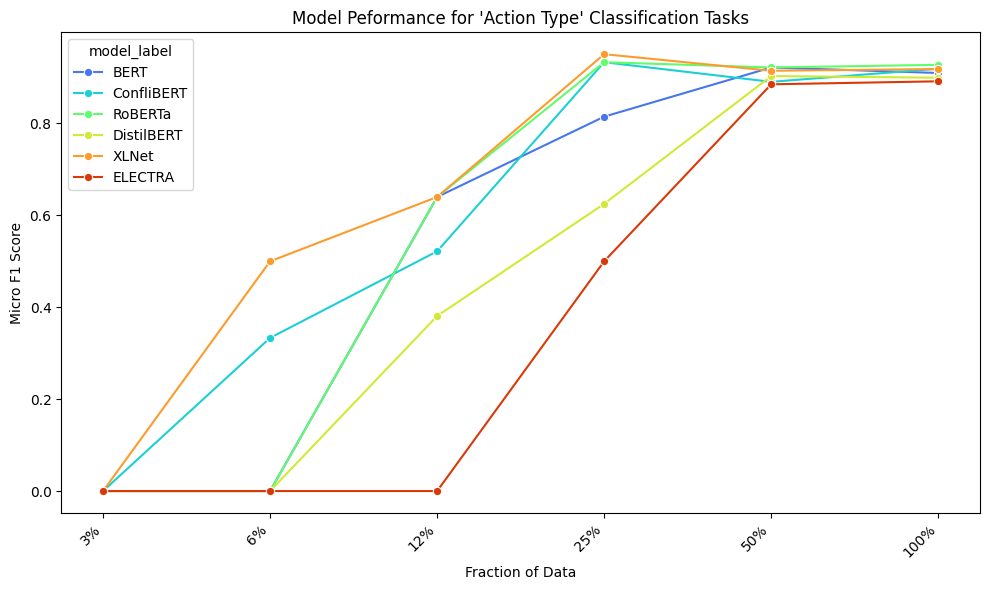

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create the plot
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=df,
    x="fraction_label",
    y="eval_micro avg_f1-score",
    hue="model_label",
    marker="o",
    palette="turbo"
    )

# Customize the plot
plt.xlabel("Fraction of Data")
plt.ylabel("Micro F1 Score")
plt.title("Model Peformance for 'Action Type' Classification Tasks")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()


### Heatmap of individual labels

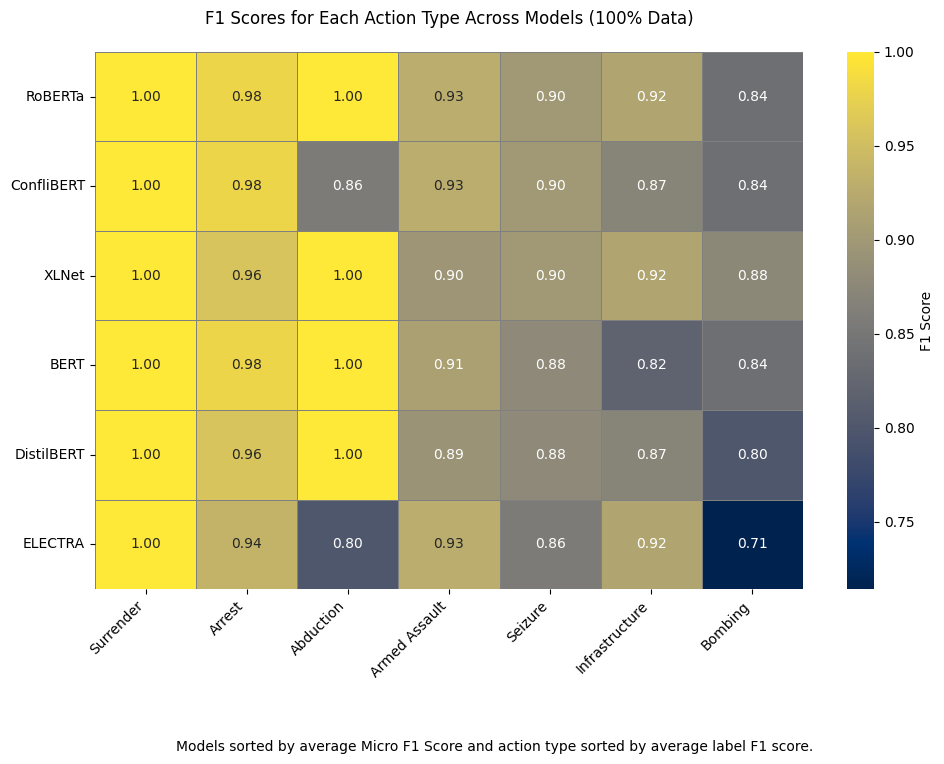

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Filter the dataset for models trained on 100% of the data
df_100 = df[df["fraction_label"] == "100%"]

# Extract F1-score columns related to specific labels (excluding averages)
label_f1_columns = [col for col in df_100.columns if col.startswith("eval_") and "_f1-score" in col and "avg" not in col]

# Select only the relevant columns along with the model label
df_f1_100 = df_100[["model_label"] + label_f1_columns]

# Rename "ConfliBERT-scr-cased" to "ConfliBERT" for clarity
#df_f1_100["model_label"] = df_f1_100["model_label"].replace({"ConfliBERT-scr-cased": "ConfliBERT"})

# Convert data to long format for heatmap visualization
df_f1_melted_100 = df_f1_100.melt(id_vars=["model_label"], var_name="Label", value_name="F1 Score")

# Clean label names (remove "eval_" prefix and "_f1-score" suffix for readability)
df_f1_melted_100["Label"] = df_f1_melted_100["Label"].str.replace("eval_", "").str.replace("_f1-score", "").str.replace("_", " ").str.title()

# Pivot the table so that models are on the y-axis and event types on the x-axis
df_f1_pivot_100 = df_f1_melted_100.pivot(index="model_label", columns="Label", values="F1 Score")

# Remove "Incident Summary" if it exists
df_f1_pivot_100 = df_f1_pivot_100.drop(columns="Incident Summary", errors="ignore")

# Sort event types (columns) by their average F1 score across models (descending order)
event_order = df_f1_pivot_100.mean().sort_values(ascending=False).index
df_f1_pivot_100 = df_f1_pivot_100[event_order]

# Sort models (rows) by their Micro F1 score (descending order) while ensuring all models are included
df_model_avg_f1 = df_100.set_index("model_label")["eval_micro avg_f1-score"].sort_values(ascending=False)
model_order = df_model_avg_f1.index
df_f1_pivot_100 = df_f1_pivot_100.loc[model_order]

# Plot the heatmap
plt.figure(figsize=(10, 7))
ax = sns.heatmap(df_f1_pivot_100, annot=True, fmt=".2f", cmap="cividis", linewidths=0.5, linecolor="gray", cbar_kws={'label': 'F1 Score'})

# Customize the plot
ax.set_title("F1 Scores for Each Action Type Across Models (100% Data)", pad=20)

# Add a custom note
plt.figtext(0.5, -0.08,
            "Models sorted by average Micro F1 Score and action type sorted by average label F1 score.",
            ha="center", fontsize=10)

# Remove X and Y axis labels
ax.set_xlabel("")
ax.set_ylabel("")

# Move event type labels (x-axis) to the bottom
ax.xaxis.tick_bottom()
ax.xaxis.set_label_position('bottom')

# Adjust ticks
plt.xticks(rotation=45, ha="right")  # Rotate labels for readability
plt.yticks(rotation=0)

# Show the heatmap
plt.tight_layout()
plt.show()


#### Model performance vs. speed

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def scatter_plot_speed_vs_accuracy(df, x_col, y_col, hue_col, size_col, title):
    """
    Creates a scatter (bubble) plot with customizable x and y axes.

    Parameters:
    - df: DataFrame containing the data
    - x_col: Column name for the x-axis (e.g., throughput, latency)
    - y_col: Column name for the y-axis (e.g., accuracy, latency)
    - hue_col: Column name for the hue (color grouping, e.g., model name)
    - size_col: Column name for the size (bubble size, e.g., data fraction)
    - title: Custom plot title
    """

    # Initialize figure
    plt.figure(figsize=(7, 5))

    # Create scatterplot with Seaborn
    scatter = sns.scatterplot(
        data=df,
        x=x_col,
        y=y_col,
        hue=hue_col,   # Color by model
        size=size_col,  # Bubble size by fraction
        sizes=(20, 400),  # Min to max size of markers
        alpha=0.7,  # Partial transparency
        palette="turbo"
    )

    # Clean up axis labels: Remove "eval_" prefix if present
    x_label_cleaned = x_col.replace("eval_", "").replace("_", " ").title()
    y_label_cleaned = y_col.replace("eval_", "").replace("_", " ").title()

    # Labeling
    scatter.set_title(title)
    scatter.set_xlabel(x_label_cleaned)  # Use cleaned x-axis label
    scatter.set_ylabel(y_label_cleaned)  # Use cleaned y-axis label

    # Retrieve the current legend handles and labels
    handles, labels = scatter.get_legend_handles_labels()

    # Convert column values to string for correct matching
    model_names = df[hue_col].astype(str).unique()
    fraction_values = sorted(df[size_col].astype(str).unique())

    # Filter legend items dynamically
    hue_handles = [h for h, l in zip(handles, labels) if l in model_names]
    hue_labels = [l for l in labels if l in model_names]

    size_handles = [h for h, l in zip(handles, labels) if l in fraction_values]
    size_labels = [l for l in labels if l in fraction_values]

    # Create the updated legends
    hue_legend = plt.legend(hue_handles, hue_labels, title="Model Name", loc="upper left", bbox_to_anchor=(1.05, 1))
    plt.gca().add_artist(hue_legend)  # Ensure the first legend stays

    size_legend = plt.legend(size_handles, size_labels, title="Fraction Raw", loc="lower left", bbox_to_anchor=(1.05, 0))

    # Show the plot
    plt.tight_layout()
    plt.show()


#### Micro F1 vs. samples per second

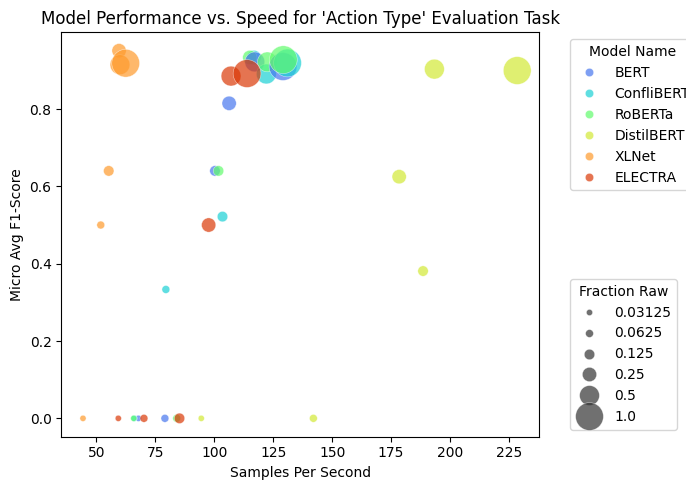

In [ ]:
scatter_plot_speed_vs_accuracy(
    df=df,
    x_col="eval_samples_per_second",
    y_col="eval_micro avg_f1-score",
    hue_col="model_label",
    size_col="fraction_raw",
    title="Model Performance vs. Speed for 'Action Type' Evaluation Task"
)